
1. Forward -> check shape
2. Backward -> numerical validation
3. Speed test
4. Overfit -> high train acccuracy
5. Plot overfit train and val accuracy
6. Print out weights
7. Tune hyperparmeters(center_dist and weight_size)
8. Compare it to Conv and FC
    - LCN: [lcn - relu] - affine - relu - affine - softmax
    - Conv: [conv - relu - 2x2 max pool] - affine - relu - affine - softmax
    - FC: [affine - relu] - affine - relu - affine - softmax
9. LCN on CIFAR-10 and CIFAR-100

# Locally Connected Neural Network

Our Final Project


In [1]:
#Use the setup that were given in assignment2/ConolutionNetworks
import numpy as np
import matplotlib.pyplot as plt
from cs682.classifiers.cnn import *
from cs682.data_utils import get_CIFAR10_data
from cs682.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from cs682.layers import *
from cs682.fast_layers import *
from cs682.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

run the following from the cs682 directory and try again:
python setup.py build_ext --inplace
You may also need to restart your iPython kernel


In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [3]:
#Import the layer and net work we implimented
from lcn import *
from lc_fc_net import *

# Locally Connected Neural Network: Naive forward pass

In [22]:
x_shape = (2, 3, 5, 5)
w_shape = (2, 2, 2, 75)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)


lcn_param = {'center_dist': 1}
out, _ = lcn_forward(x, w, b, lcn_param)

print(out.shape)


(2, 2, 2, 2)


In [24]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 2, 2, 75)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 2, 2)
lcn_param = {'center_dist': 10}

dx_num = eval_numerical_gradient_array(lambda x: lcn_forward(x, w, b, lcn_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: lcn_forward(x, w, b, lcn_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: lcn_forward(x, w, b, lcn_param)[0], b, dout)

out, cache = lcn_forward(x, w, b, lcn_param)
dx, dw, db = lcn_backward(dout, cache)

# Your errors should be around e-8 or less.
print('Testing lcn_backward function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing lcn_backward function
dx error:  2.967892731527532e-08
dw error:  2.710832479161312e-07
db error:  3.2756543587575794e-12


# Speed test

In [28]:
# Compare the time with conv_naive
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
w_conv = np.random.randn(32, 3, 5, 5)
w_lcn = np.random.randn(2, 5, 5, 3072)
b_conv = np.random.randn(32,)
b_lcn = np.random.randn(2,)
dout_conv = np.random.randn(100, 32, 32, 32)
dout_lcn = np.random.randn(100, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 2}
lcn_param = {'center_dist': 10}


t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w_conv, b_conv, conv_param)
t1 = time()
out_lcn, cache_lcn = lcn_forward(x, w_lcn, b_lcn, lcn_param)
t2 = time()

print('Testing lcn_forward:')
print('Conv: %fs' % (t1 - t0))
print('LCN: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout_conv, cache_naive)
t1 = time()
dx_lcn, dw_lcn, db_lcn = lcn_backward(dout_lcn, cache_lcn)
t2 = time()

print('Testing lcn_backward:')
print('Conv: %fs' % (t1 - t0))
print('LCN: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))

Testing lcn_forward:
Conv: 23.070871s
LCN: 0.249119s
Speedup: 92.609825x
Testing lcn_backward:
Conv: 36.127207s
LCN: 0.353023s
Speedup: 102.336750x


## Overfit

In [7]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerLCNNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet: %fs' % (t1 - t0))

(Iteration 1 / 30) loss: 2.303085
(Epoch 0 / 15) train acc: 0.190000; val_acc: 0.114000
(Iteration 2 / 30) loss: 2.297378
(Epoch 1 / 15) train acc: 0.160000; val_acc: 0.117000
(Iteration 3 / 30) loss: 2.291885
(Iteration 4 / 30) loss: 2.278358
(Epoch 2 / 15) train acc: 0.210000; val_acc: 0.127000
(Iteration 5 / 30) loss: 2.272711
(Iteration 6 / 30) loss: 2.249300
(Epoch 3 / 15) train acc: 0.190000; val_acc: 0.138000
(Iteration 7 / 30) loss: 2.240283
(Iteration 8 / 30) loss: 2.211211
(Epoch 4 / 15) train acc: 0.190000; val_acc: 0.137000
(Iteration 9 / 30) loss: 2.190593
(Iteration 10 / 30) loss: 2.079509
(Epoch 5 / 15) train acc: 0.190000; val_acc: 0.138000
(Iteration 11 / 30) loss: 2.119107
(Iteration 12 / 30) loss: 2.151853
(Epoch 6 / 15) train acc: 0.190000; val_acc: 0.138000
(Iteration 13 / 30) loss: 2.070984
(Iteration 14 / 30) loss: 2.026814
(Epoch 7 / 15) train acc: 0.210000; val_acc: 0.143000
(Iteration 15 / 30) loss: 2.065783
(Iteration 16 / 30) loss: 1.929231
(Epoch 8 / 15) tr

In [8]:
np.random.seed(231)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerLCNNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=30, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet: %fs' % (t1 - t0))

(Iteration 1 / 60) loss: 2.303085
(Epoch 0 / 30) train acc: 0.190000; val_acc: 0.114000
(Iteration 2 / 60) loss: 2.297378
(Epoch 1 / 30) train acc: 0.160000; val_acc: 0.117000
(Iteration 3 / 60) loss: 2.291885
(Iteration 4 / 60) loss: 2.278358
(Epoch 2 / 30) train acc: 0.210000; val_acc: 0.127000
(Iteration 5 / 60) loss: 2.272711
(Iteration 6 / 60) loss: 2.249300
(Epoch 3 / 30) train acc: 0.190000; val_acc: 0.138000
(Iteration 7 / 60) loss: 2.240283
(Iteration 8 / 60) loss: 2.211211
(Epoch 4 / 30) train acc: 0.190000; val_acc: 0.137000
(Iteration 9 / 60) loss: 2.190593
(Iteration 10 / 60) loss: 2.079509
(Epoch 5 / 30) train acc: 0.190000; val_acc: 0.138000
(Iteration 11 / 60) loss: 2.119107
(Iteration 12 / 60) loss: 2.151853
(Epoch 6 / 30) train acc: 0.190000; val_acc: 0.138000
(Iteration 13 / 60) loss: 2.070984
(Iteration 14 / 60) loss: 2.026814
(Epoch 7 / 30) train acc: 0.210000; val_acc: 0.143000
(Iteration 15 / 60) loss: 2.065783
(Iteration 16 / 60) loss: 1.929231
(Epoch 8 / 30) tr

## Plot
Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

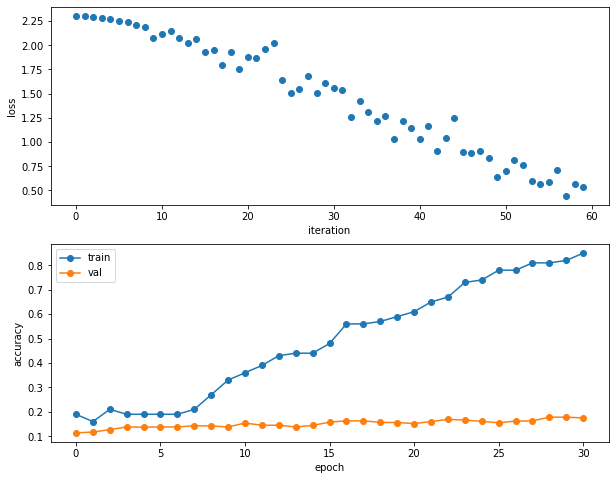

In [9]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net


In [46]:
# Fixed parameters
input_dim = (3, 32, 32)
hidden_dim = 500
num_classes = 10
weight_scale = 1e-2
reg = 1e-3

num_filters = 1
weight_size = 7
center_dist = 15

model = ThreeLayerLCNNet(input_dim,
                         num_filters,
                         weight_size,
                         hidden_dim,
                         num_classes,
                         weight_scale,
                         reg,
                         center_dist
                        )

solver = Solver(model, data,
                num_epochs=2, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet train: %fs' % (t1 - t0))

(Iteration 1 / 1960) loss: 2.311606
(Epoch 0 / 2) train acc: 0.098000; val_acc: 0.113000
(Iteration 21 / 1960) loss: 2.115759
(Iteration 41 / 1960) loss: 1.890487
(Iteration 61 / 1960) loss: 1.830246
(Iteration 81 / 1960) loss: 1.937554
(Iteration 101 / 1960) loss: 1.904250
(Iteration 121 / 1960) loss: 1.846927
(Iteration 141 / 1960) loss: 1.685736
(Iteration 161 / 1960) loss: 1.945504
(Iteration 181 / 1960) loss: 1.748469
(Iteration 201 / 1960) loss: 1.850802
(Iteration 221 / 1960) loss: 1.929778
(Iteration 241 / 1960) loss: 1.855614
(Iteration 261 / 1960) loss: 1.763523
(Iteration 281 / 1960) loss: 1.749339
(Iteration 301 / 1960) loss: 1.968100
(Iteration 321 / 1960) loss: 1.765941
(Iteration 341 / 1960) loss: 1.613458
(Iteration 361 / 1960) loss: 1.698455
(Iteration 381 / 1960) loss: 1.602365
(Iteration 401 / 1960) loss: 1.779548
(Iteration 421 / 1960) loss: 1.959572
(Iteration 441 / 1960) loss: 1.722317
(Iteration 461 / 1960) loss: 1.565727
(Iteration 481 / 1960) loss: 1.704551
(It

## Print out weights

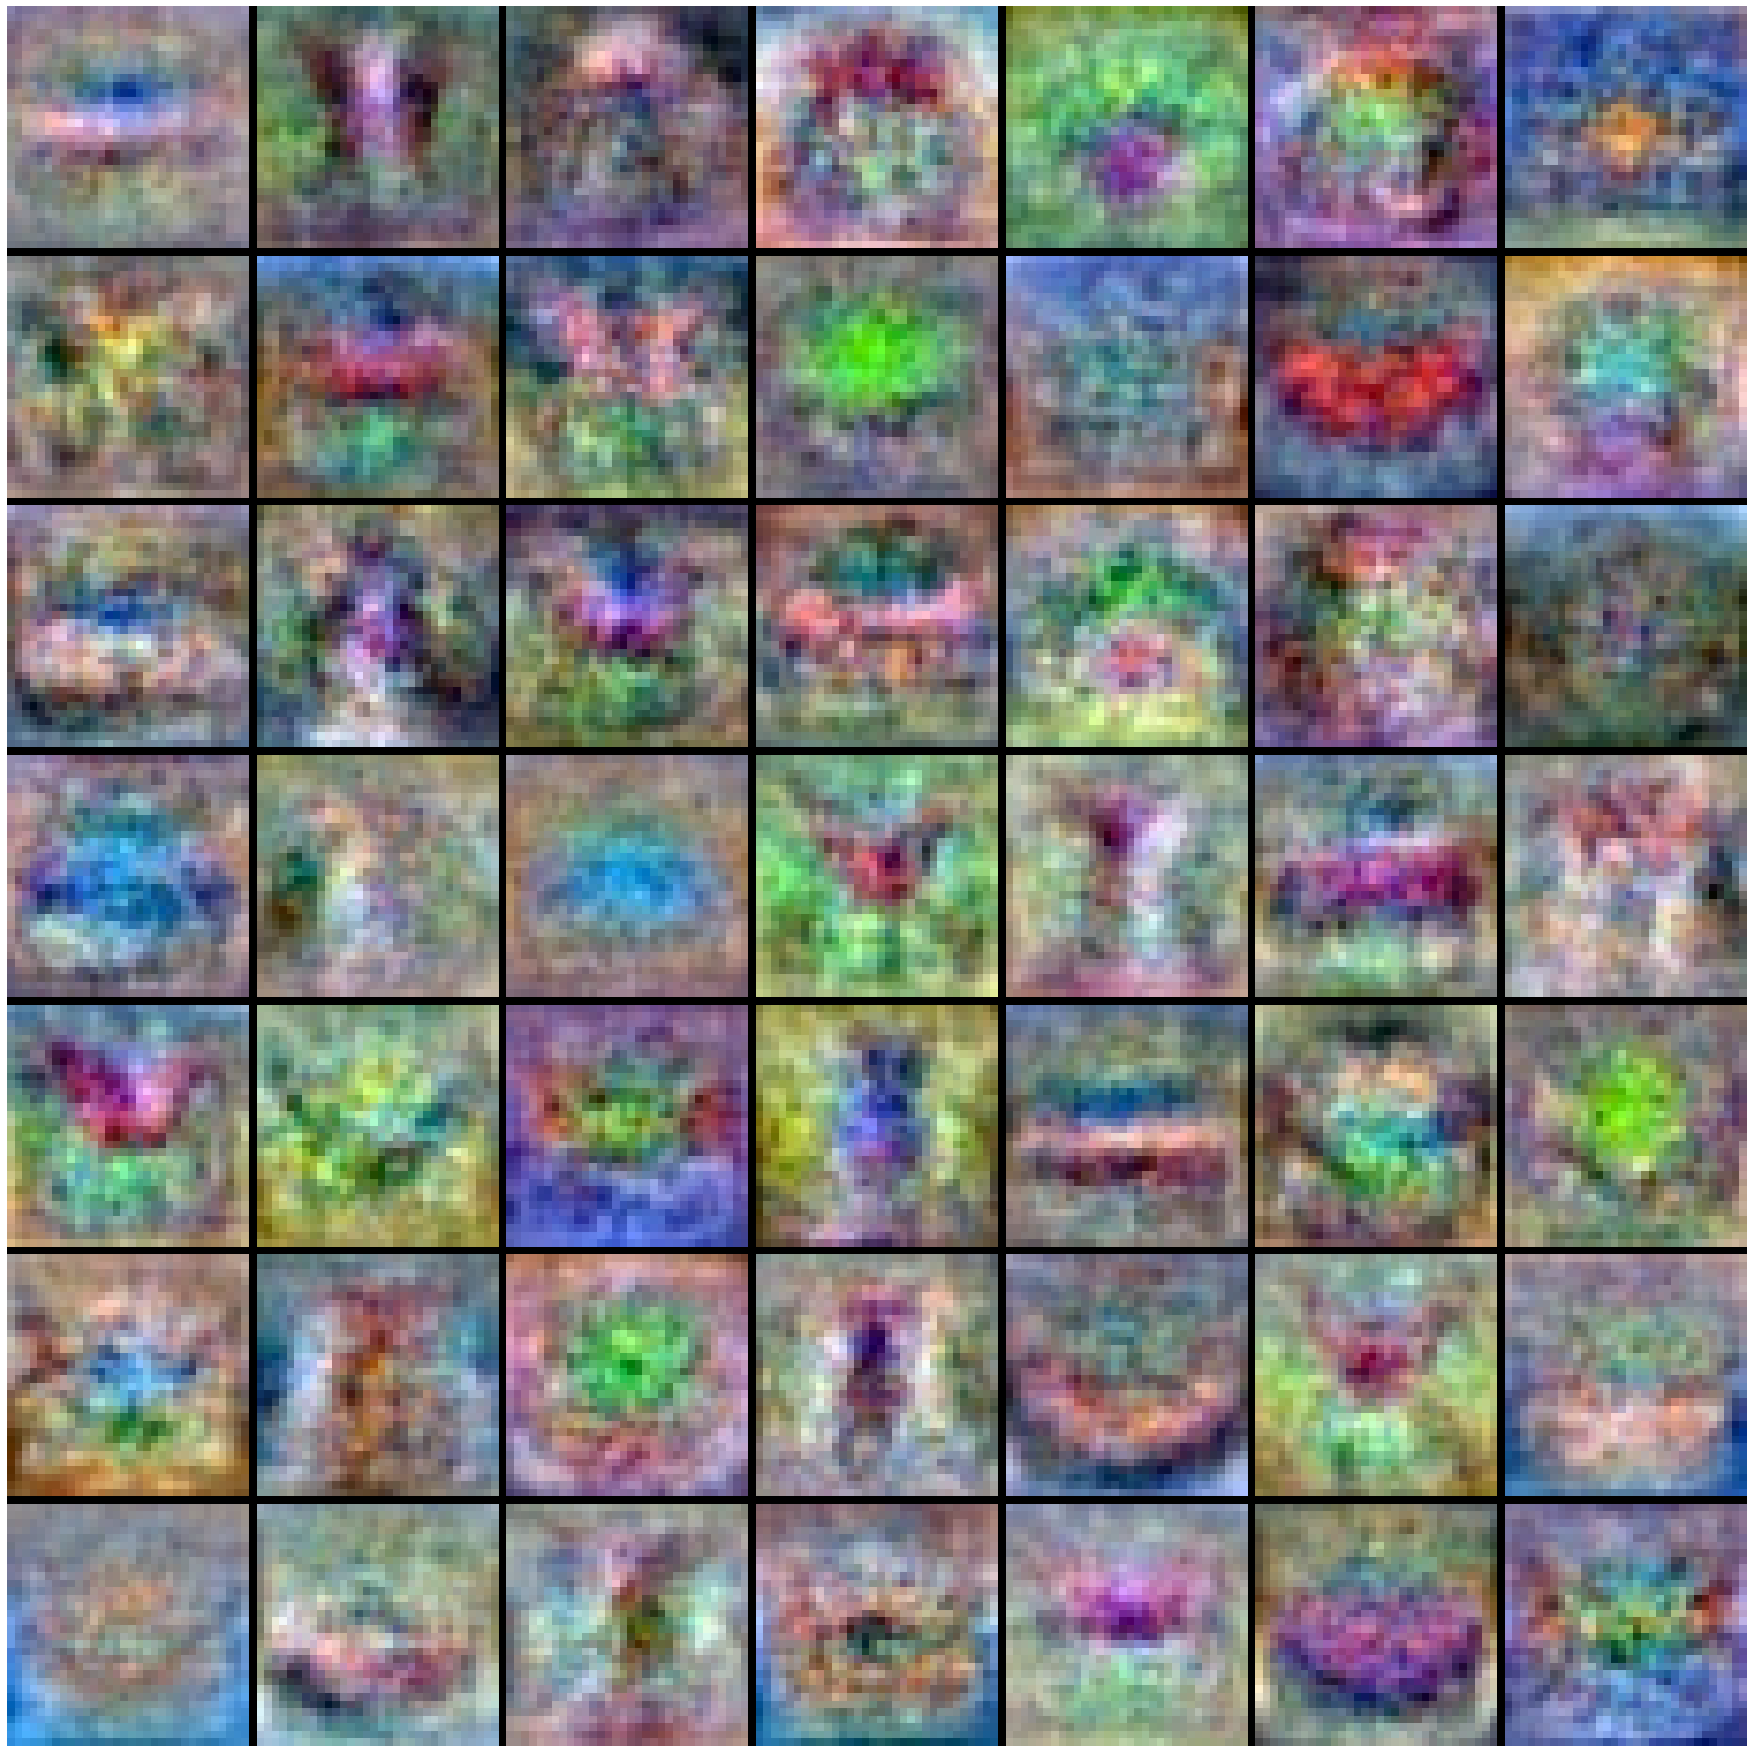

In [47]:
# Visualize the learned weights for each class
w = model.params['W1'].reshape(49, 3, 32, 32).transpose(0,2,3,1)

grid = visualize_grid(w)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(32, 32)
plt.show()



## Tune Hyperparameters

In [48]:
best_model = None # stroe the best model into this

# Fixed parameters
input_dim = (3, 32, 32)
num_filters = 1
hidden_dim = 500
num_classes = 10
weight_scale = 1e-2
reg = 1e-3

# Hyperparameters to be tune
weight_sizes = [7]
center_dists = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]


# Test loop
results = {}
times = {}
weights = {}
best_val = -1

for weight_size in weight_sizes:
    for center_dist in center_dists:
        print('Now testing weight_size %f center_dist %f' % (weight_size, center_dist))
        
        model = ThreeLayerLCNNet(input_dim,
                                 num_filters,
                                 weight_size,
                                 hidden_dim,
                                 num_classes,
                                 weight_scale,
                                 reg,
                                 center_dist
                                )


        solver = Solver(model, data,
                        num_epochs=2, batch_size=50,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': 1e-3,
                        },
                        verbose=True, print_every=980)

        t0 = time()
        solver.train()
        t1 = time()
        
        times[(weight_size, center_dist)] = t1 - t0
        print('Time for traning weight_size %f center_dist %f' % (weight_size, center_dist))
        print('ThreeLayerLCNNet train time: %fs' % (t1 - t0))
        print()
        
        results[(weight_size, center_dist)] = solver.best_val_acc
        weights[(weight_size, center_dist)] = model.params['W1'].transpose(0, 2, 3, 1) 
        
        if solver.best_val_acc > best_val:
            best_model = model
            best_val = solver.best_val_acc
            




Now testing weight_size 7.000000 center_dist 1.000000
(Iteration 1 / 1960) loss: 2.310961
(Epoch 0 / 2) train acc: 0.175000; val_acc: 0.150000
(Epoch 1 / 2) train acc: 0.423000; val_acc: 0.431000
(Iteration 981 / 1960) loss: 1.374710
(Epoch 2 / 2) train acc: 0.513000; val_acc: 0.481000
Time for traning weight_size 7.000000 center_dist 1.000000
ThreeLayerLCNNet train time: 612.555707s

Now testing weight_size 7.000000 center_dist 5.000000
(Iteration 1 / 1960) loss: 2.311413
(Epoch 0 / 2) train acc: 0.149000; val_acc: 0.115000
(Epoch 1 / 2) train acc: 0.451000; val_acc: 0.452000
(Iteration 981 / 1960) loss: 1.769973
(Epoch 2 / 2) train acc: 0.520000; val_acc: 0.489000
Time for traning weight_size 7.000000 center_dist 5.000000
ThreeLayerLCNNet train time: 607.637308s

Now testing weight_size 7.000000 center_dist 10.000000
(Iteration 1 / 1960) loss: 2.311839
(Epoch 0 / 2) train acc: 0.140000; val_acc: 0.138000
(Epoch 1 / 2) train acc: 0.472000; val_acc: 0.469000
(Iteration 981 / 1960) loss

In [53]:
# Print out results
for weight_size, center_dist in sorted(results):
    val_acc = results[(weight_size, center_dist)]
    test_time = times[(weight_size, center_dist)]
    print('weight_size %.2f center_dist %.2f val accuracy: %.4f time: %.1fs' % (weight_size, center_dist, val_acc, test_time))

print('Best validation accuracy achieved: %f' % best_val)


weight_size 7.00 center_dist 1.00 val accuracy: 0.4810 time: 612.6s
weight_size 7.00 center_dist 5.00 val accuracy: 0.4890 time: 607.6s
weight_size 7.00 center_dist 10.00 val accuracy: 0.4930 time: 607.1s
weight_size 7.00 center_dist 15.00 val accuracy: 0.5050 time: 607.0s
weight_size 7.00 center_dist 20.00 val accuracy: 0.5030 time: 605.9s
weight_size 7.00 center_dist 25.00 val accuracy: 0.4800 time: 604.9s
weight_size 7.00 center_dist 30.00 val accuracy: 0.4840 time: 625.2s
weight_size 7.00 center_dist 35.00 val accuracy: 0.4940 time: 624.6s
weight_size 7.00 center_dist 40.00 val accuracy: 0.4580 time: 624.3s
weight_size 7.00 center_dist 45.00 val accuracy: 0.4460 time: 624.7s
weight_size 7.00 center_dist 50.00 val accuracy: 0.4570 time: 627.6s
weight_size 7.00 center_dist 55.00 val accuracy: 0.4470 time: 626.8s
Best validation accuracy achieved: 0.505000


Plot weights for weight_size 7.000000 center_dist 1.000000


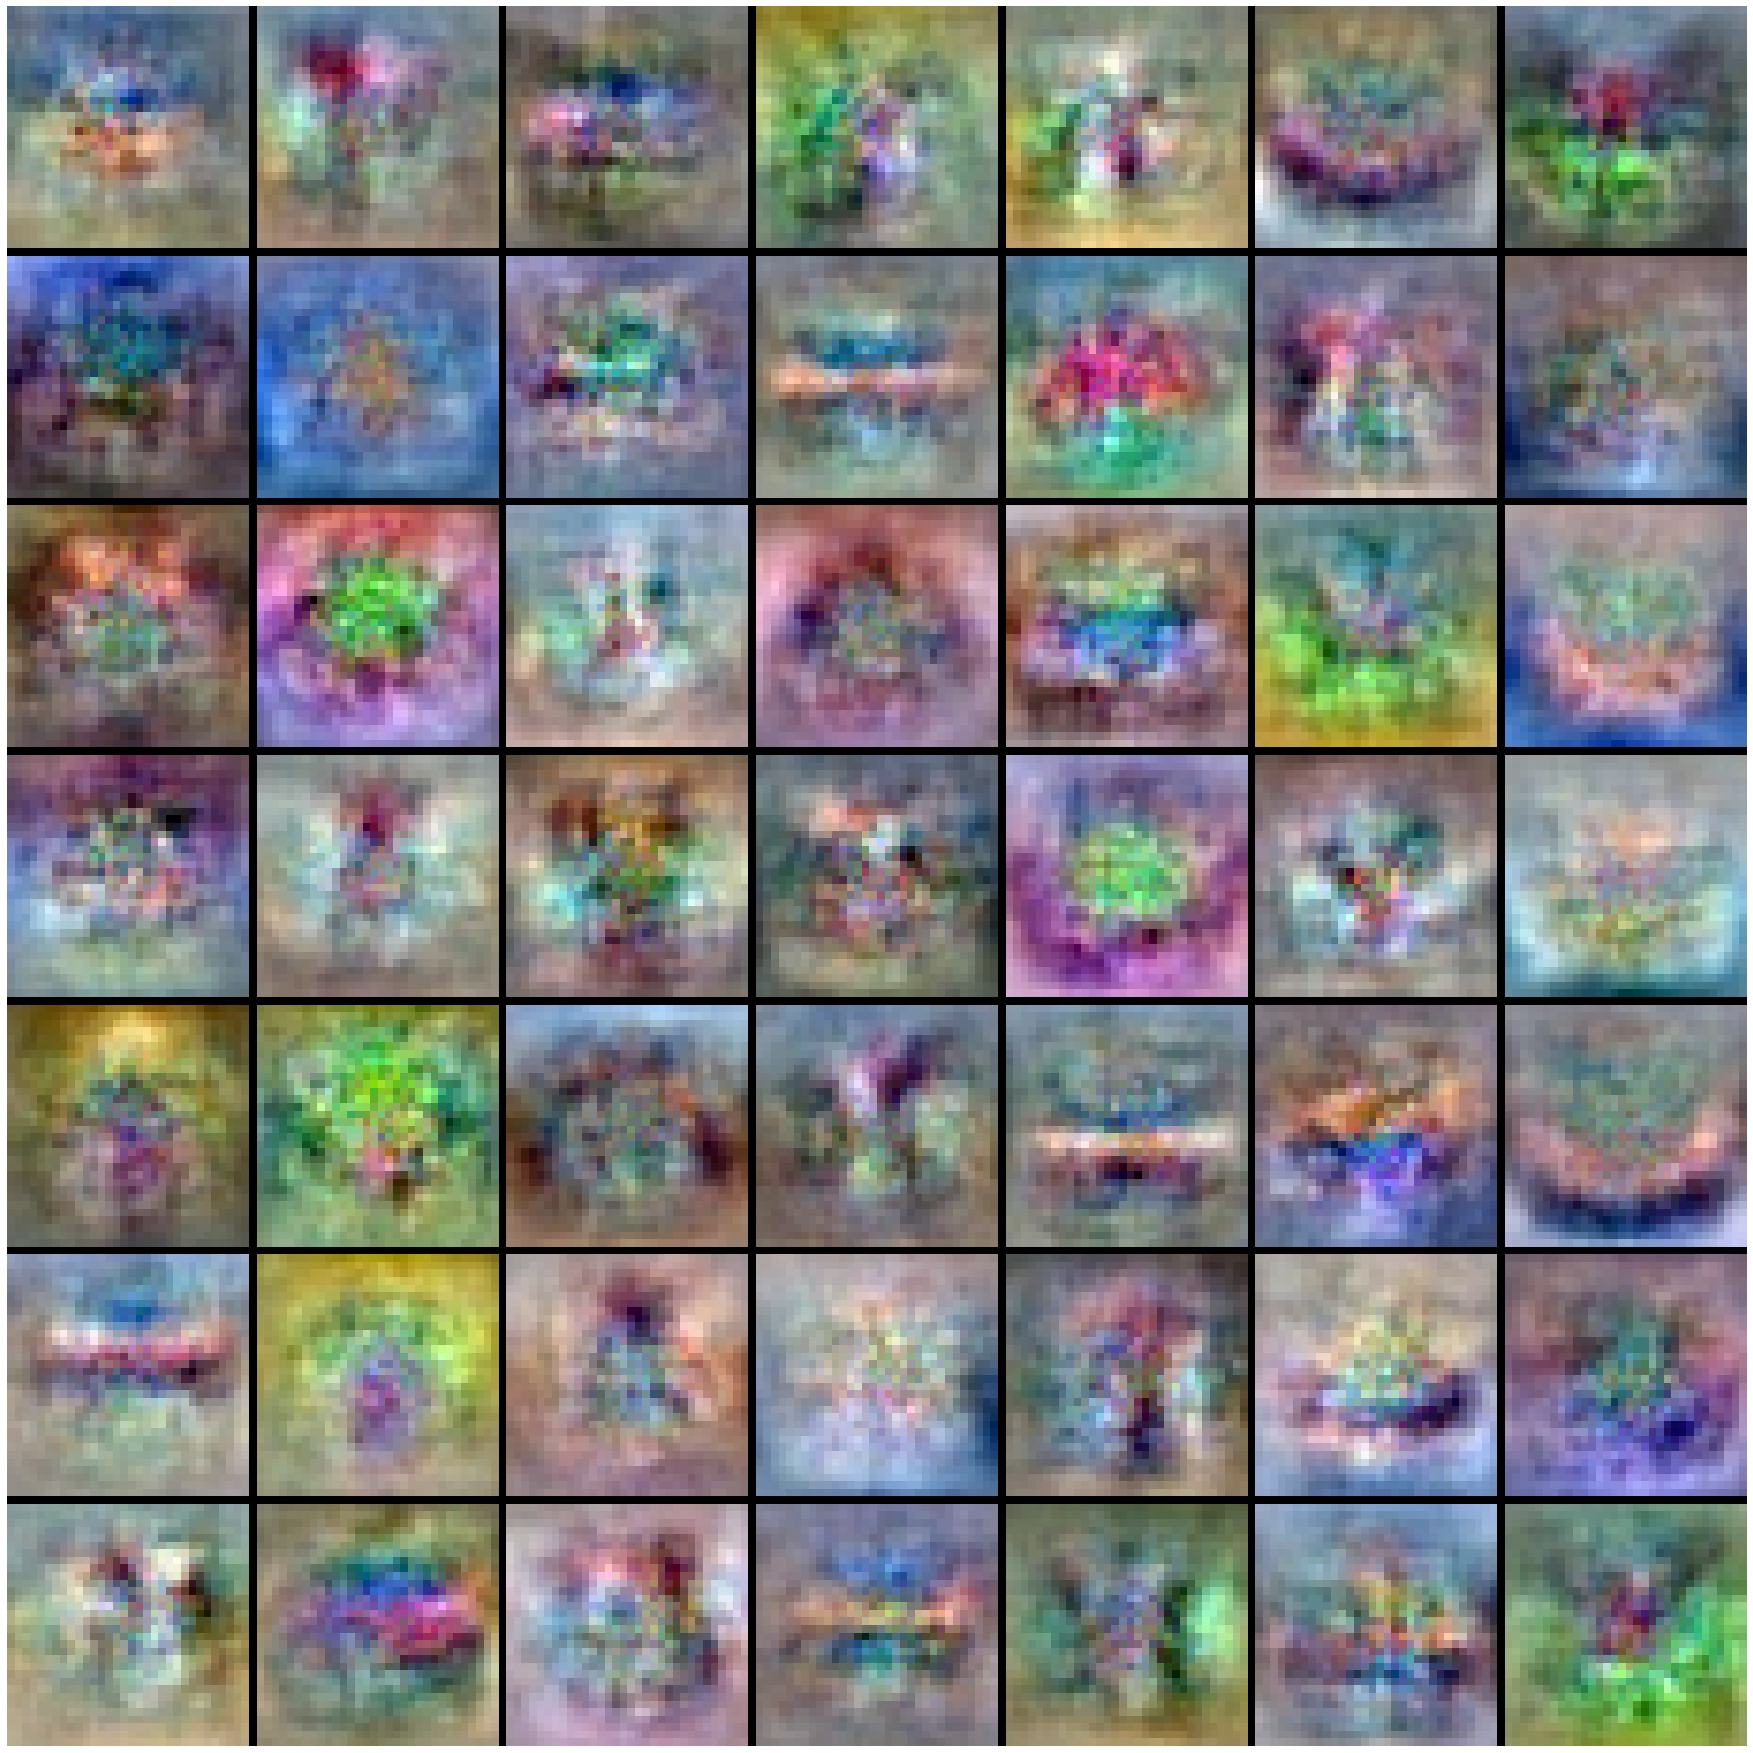

Plot weights for weight_size 7.000000 center_dist 5.000000


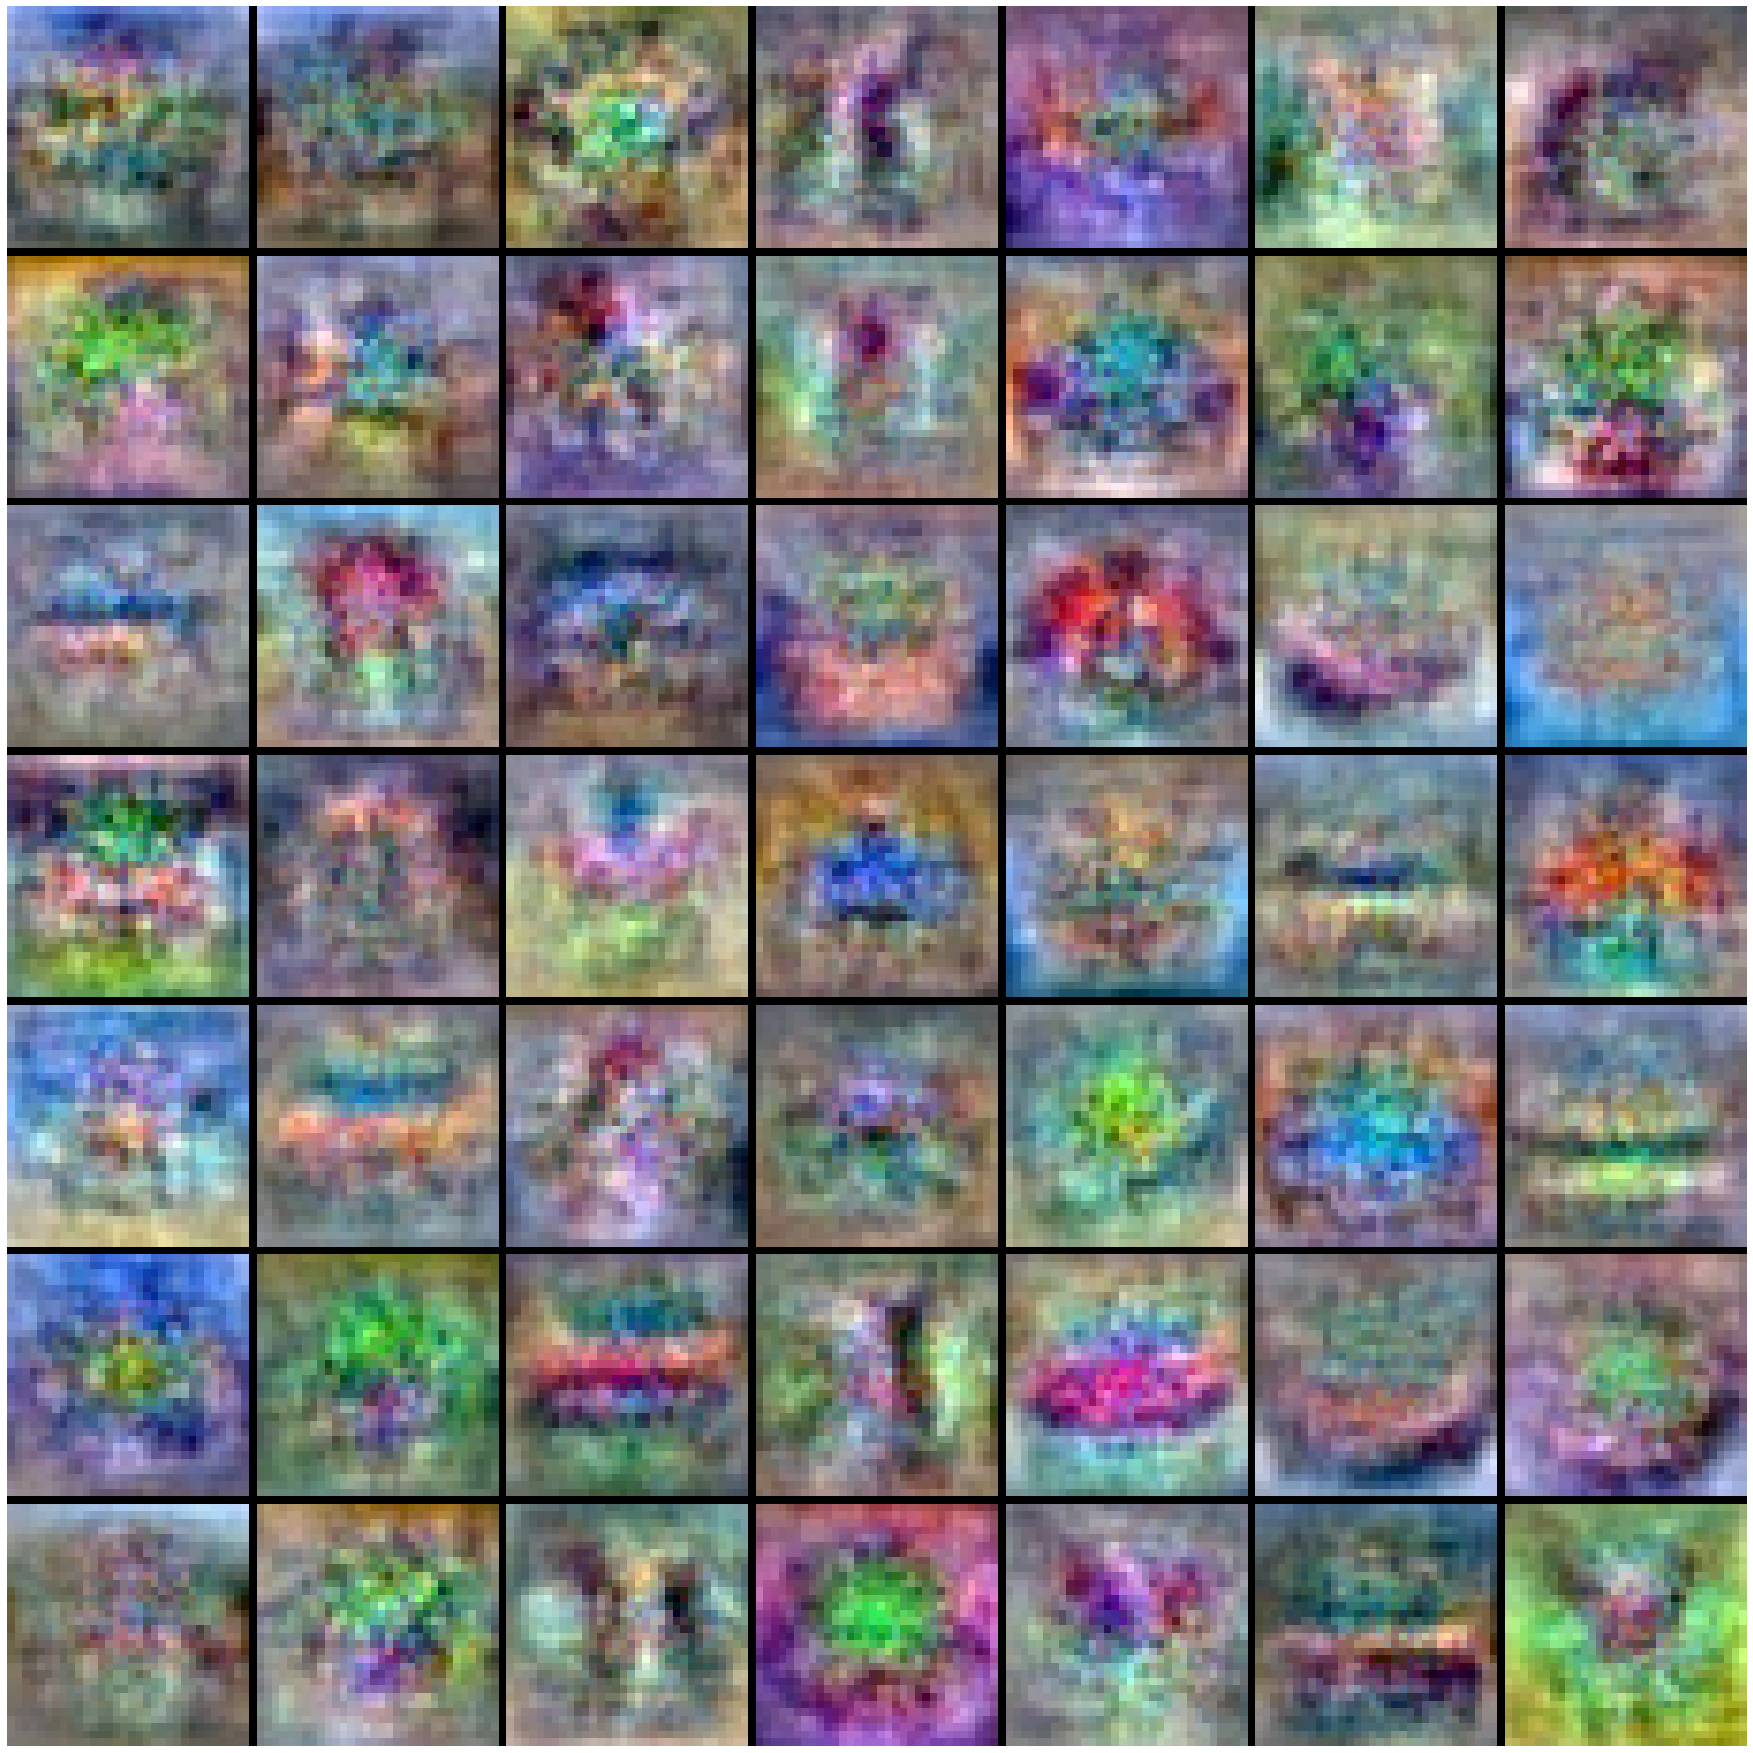

Plot weights for weight_size 7.000000 center_dist 10.000000


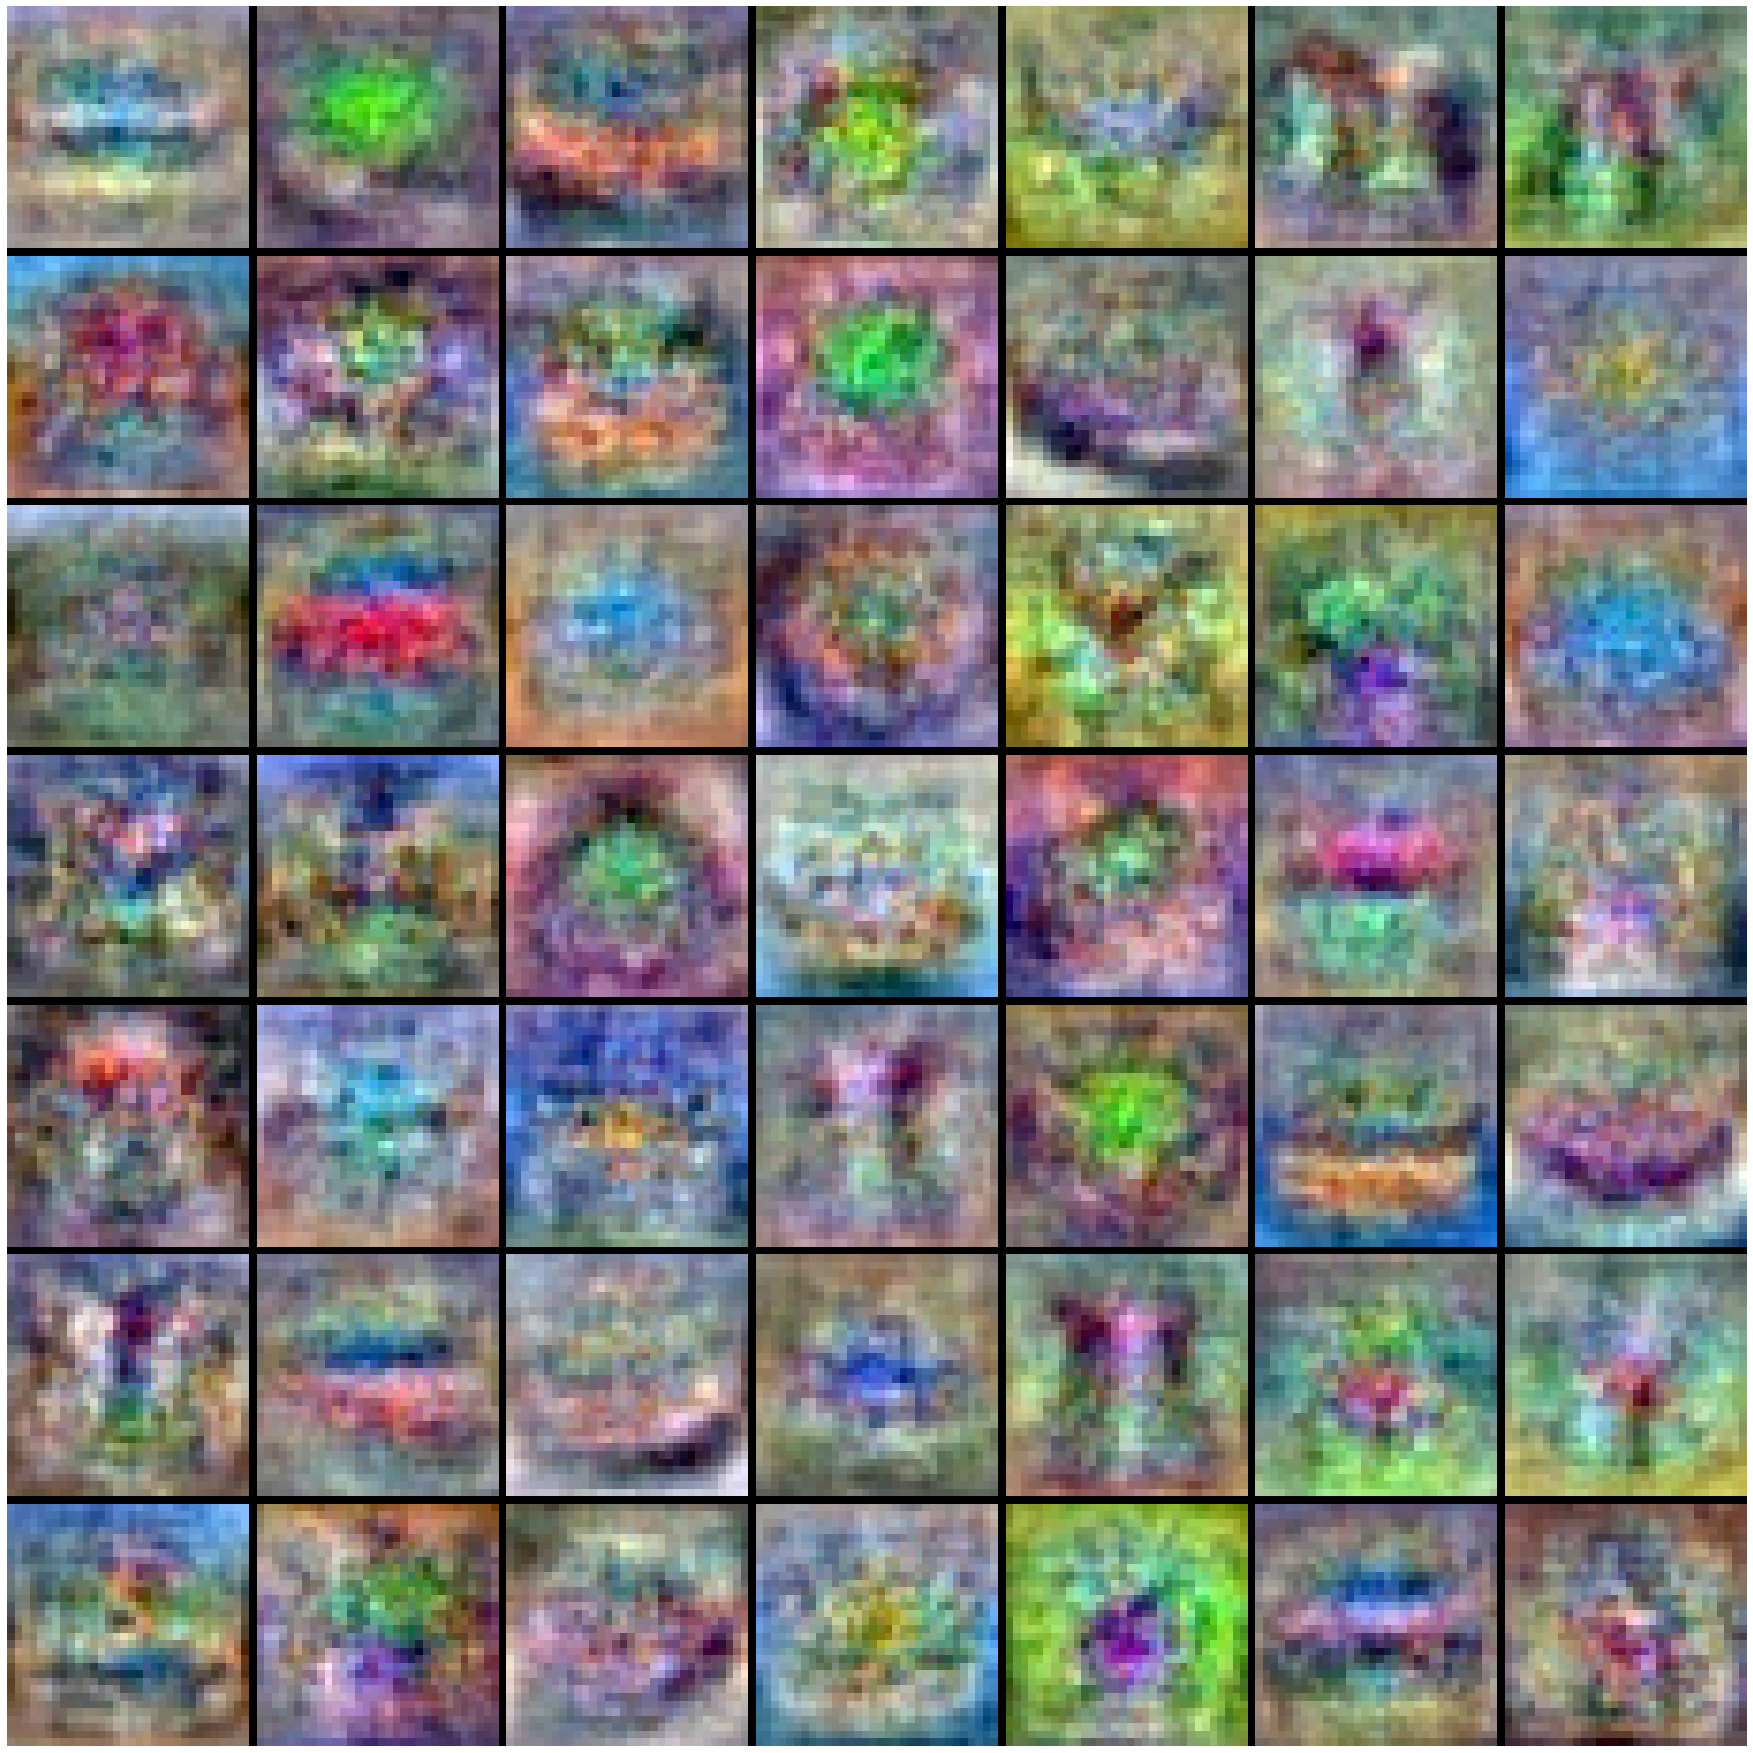

Plot weights for weight_size 7.000000 center_dist 15.000000


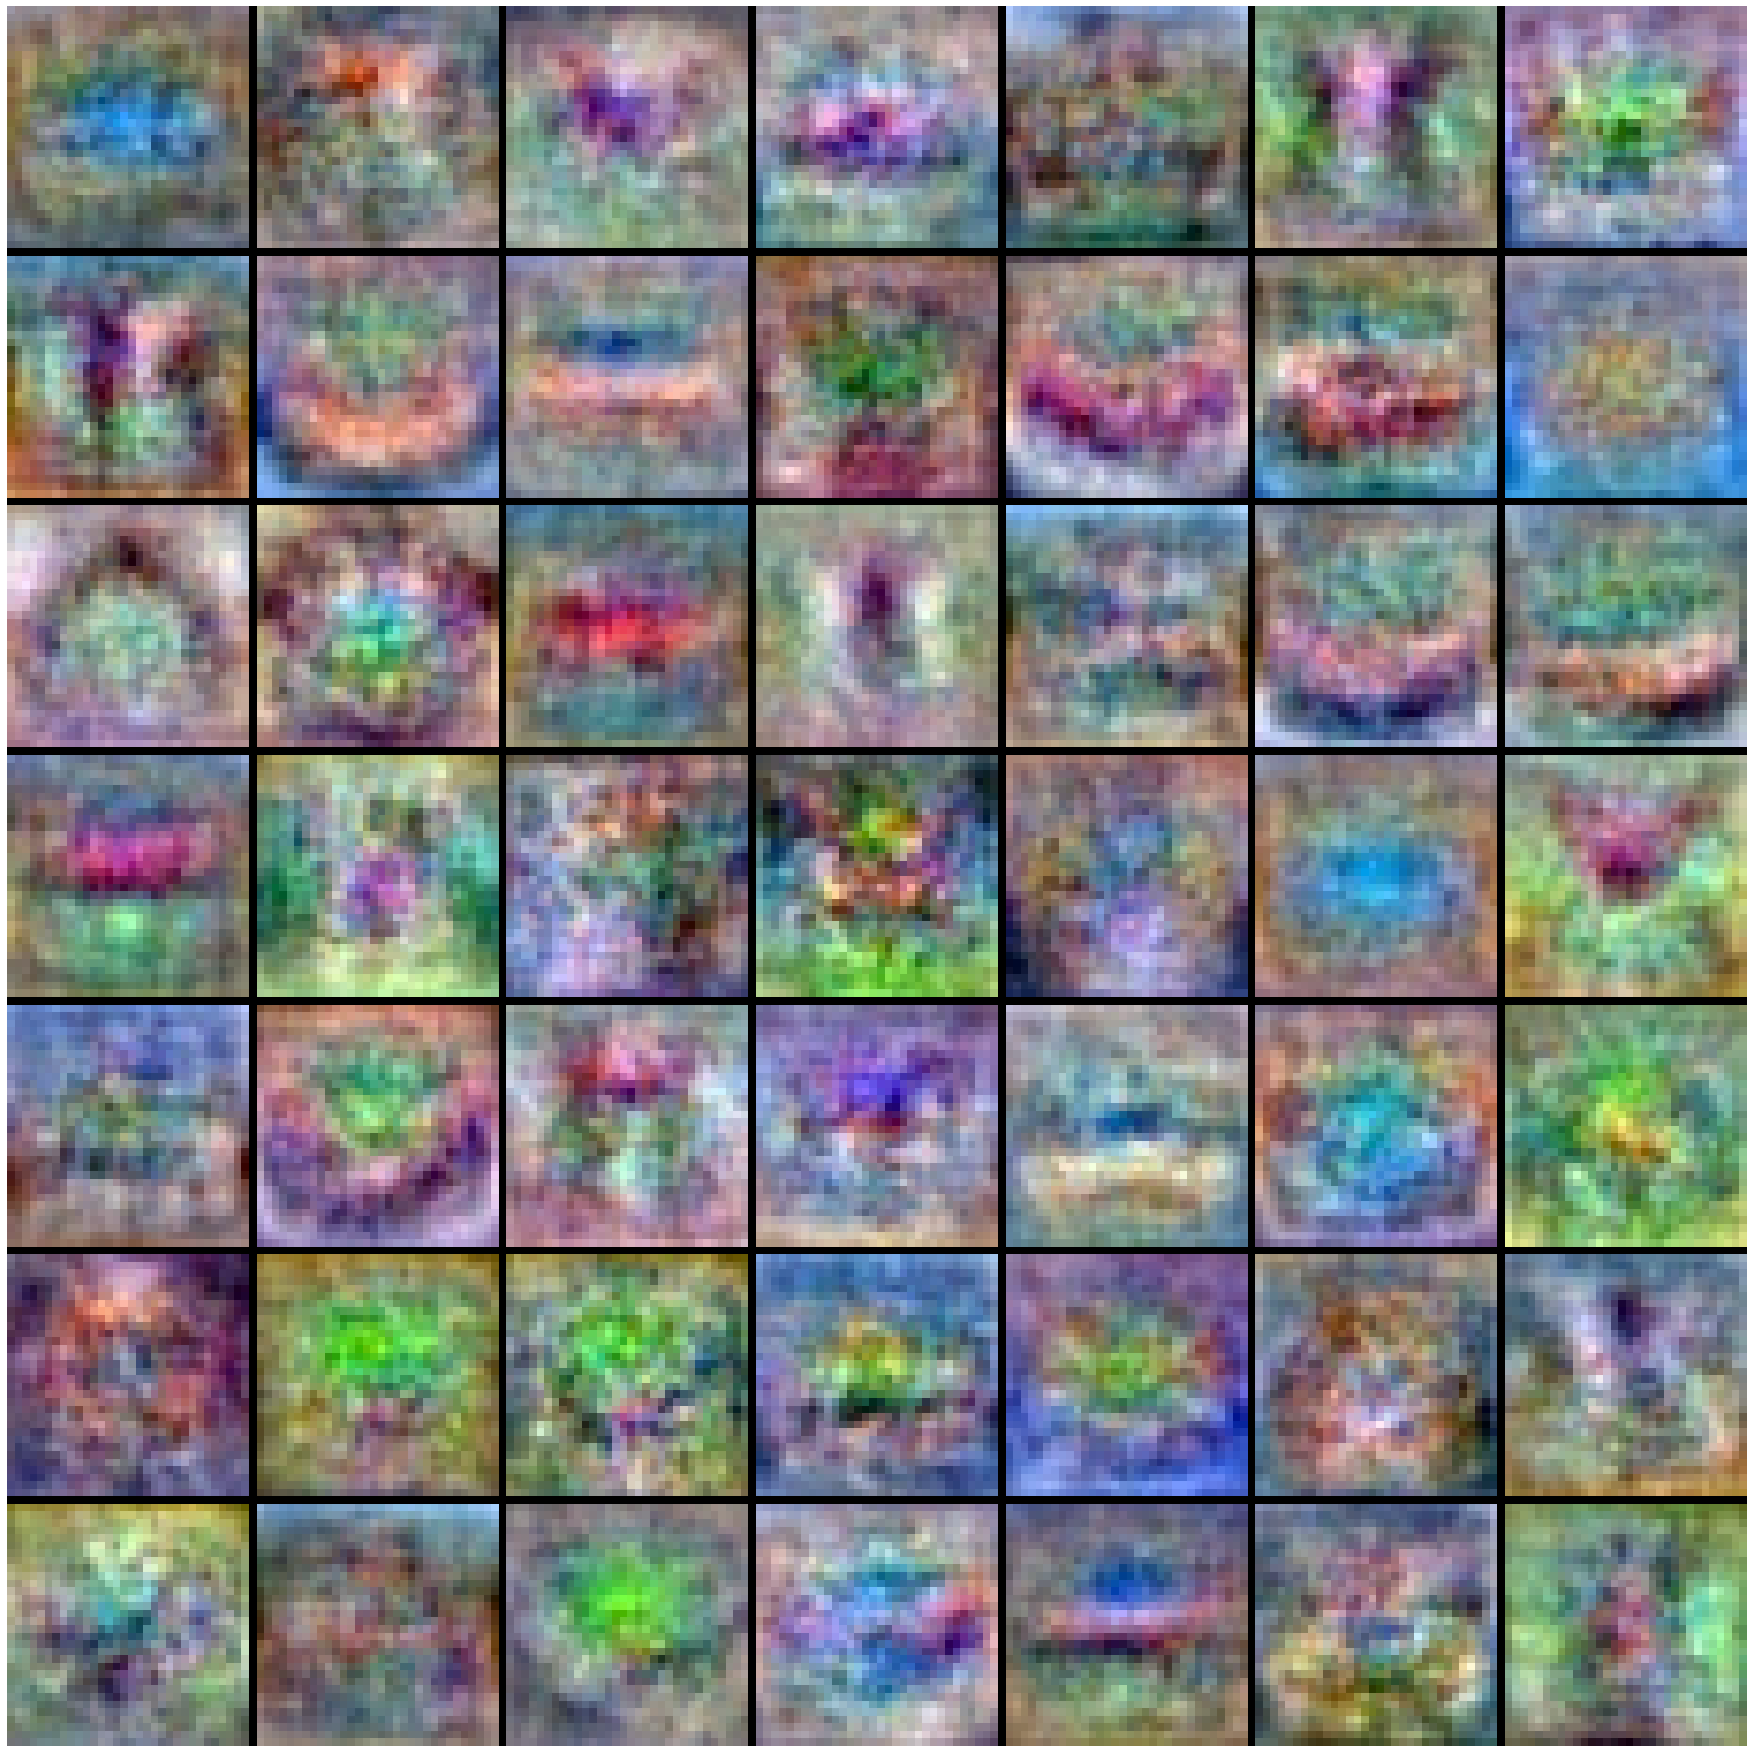

Plot weights for weight_size 7.000000 center_dist 20.000000


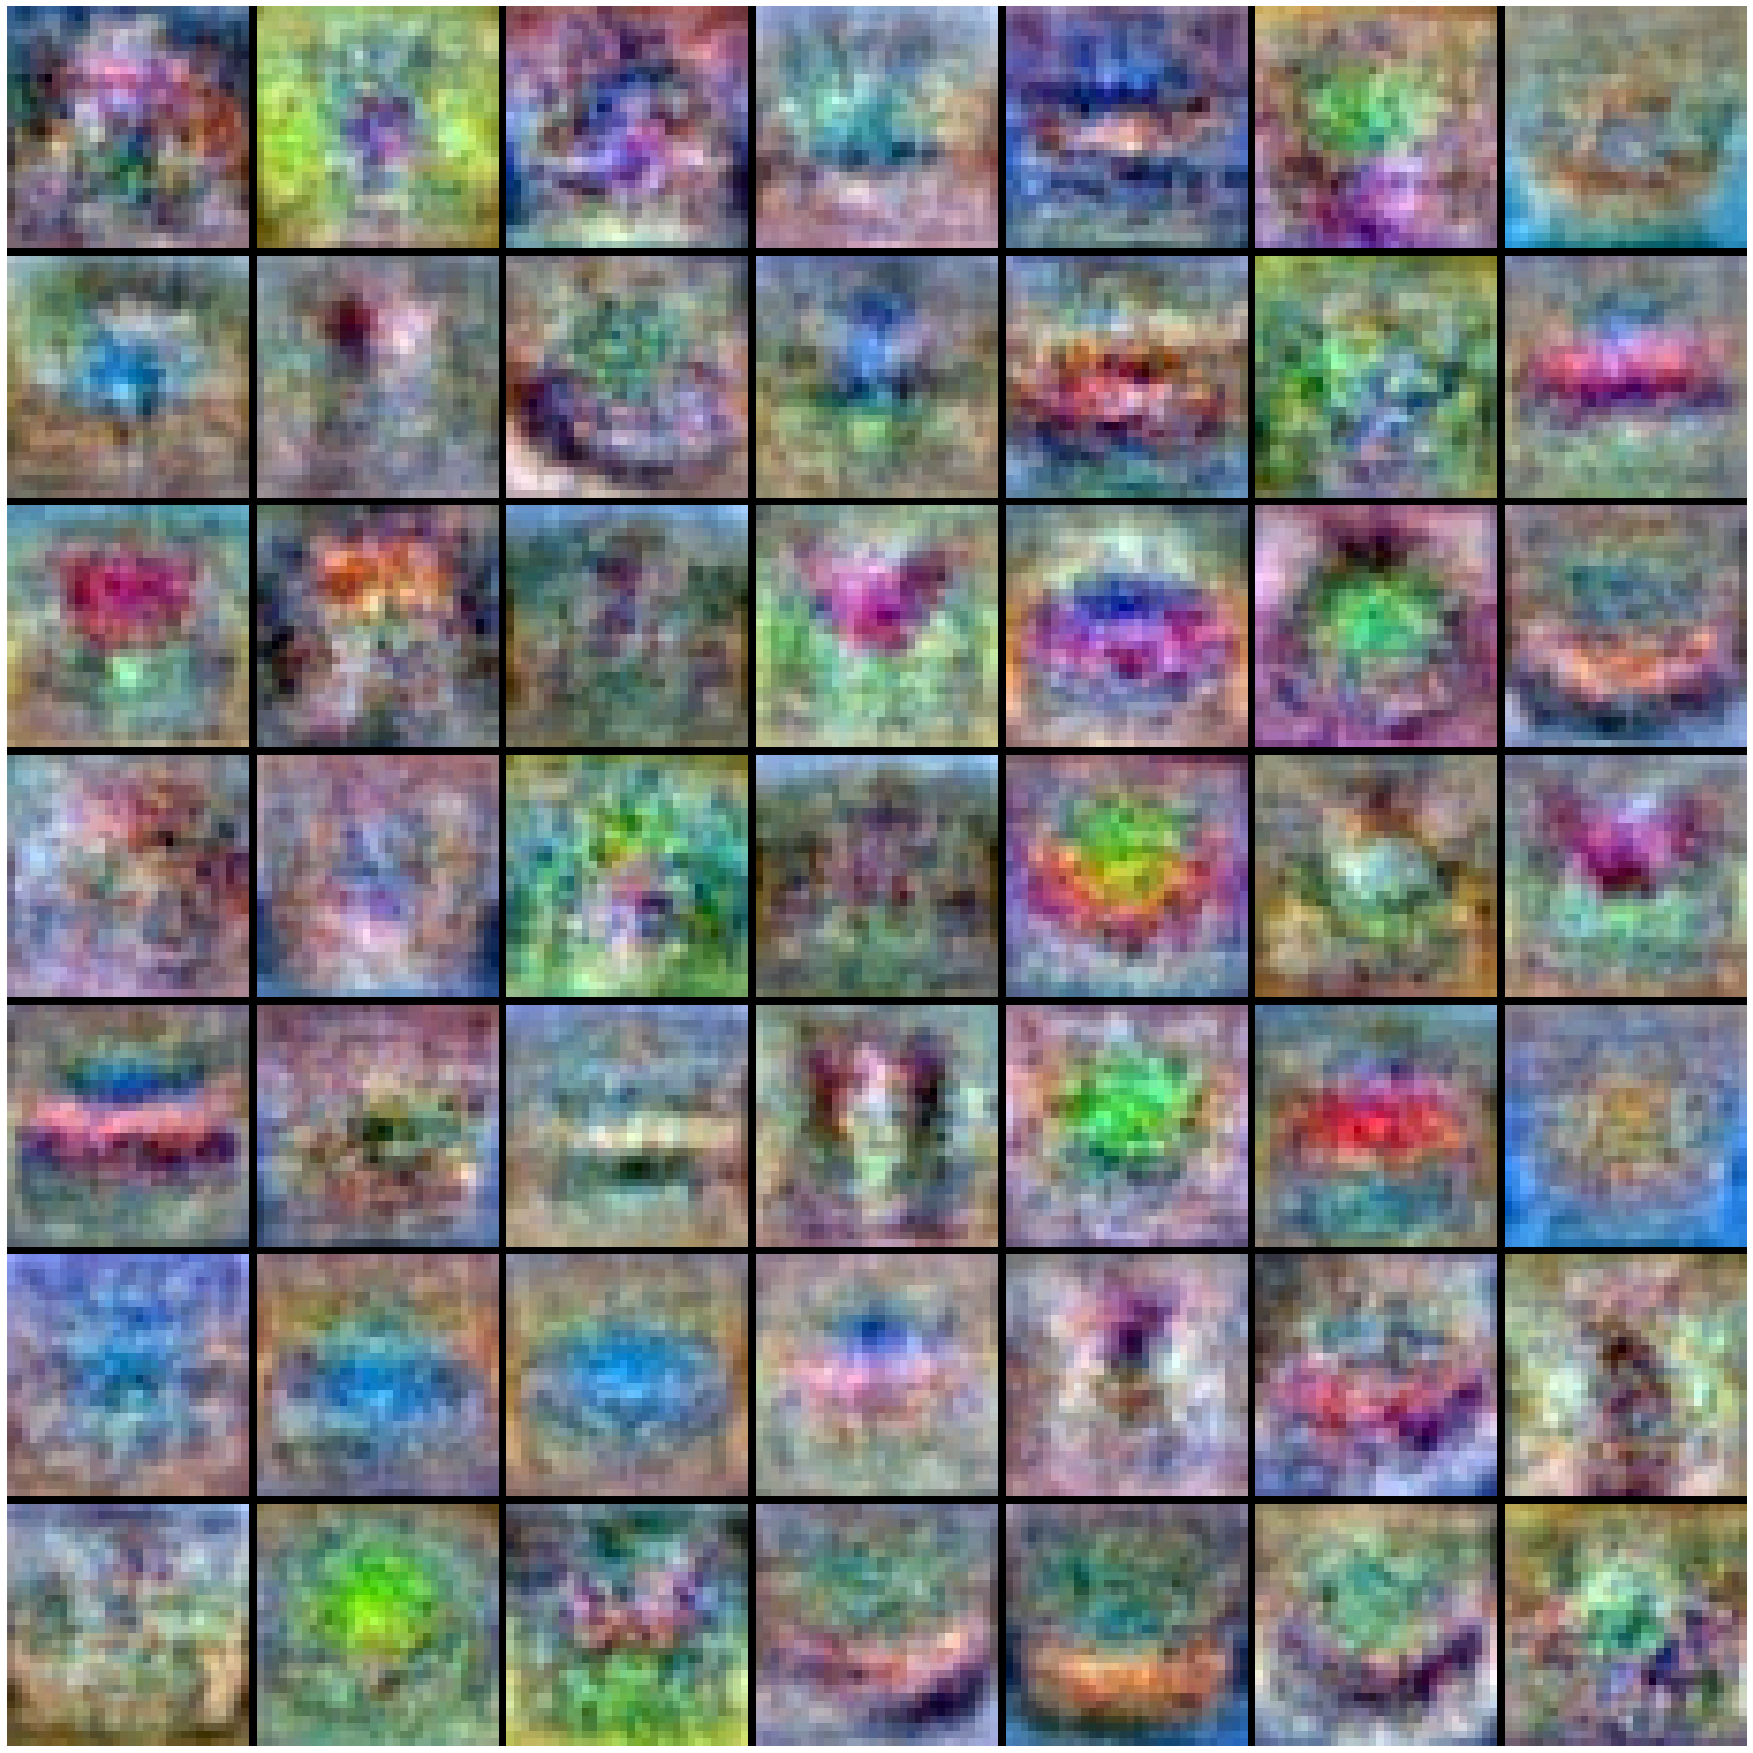

Plot weights for weight_size 7.000000 center_dist 25.000000


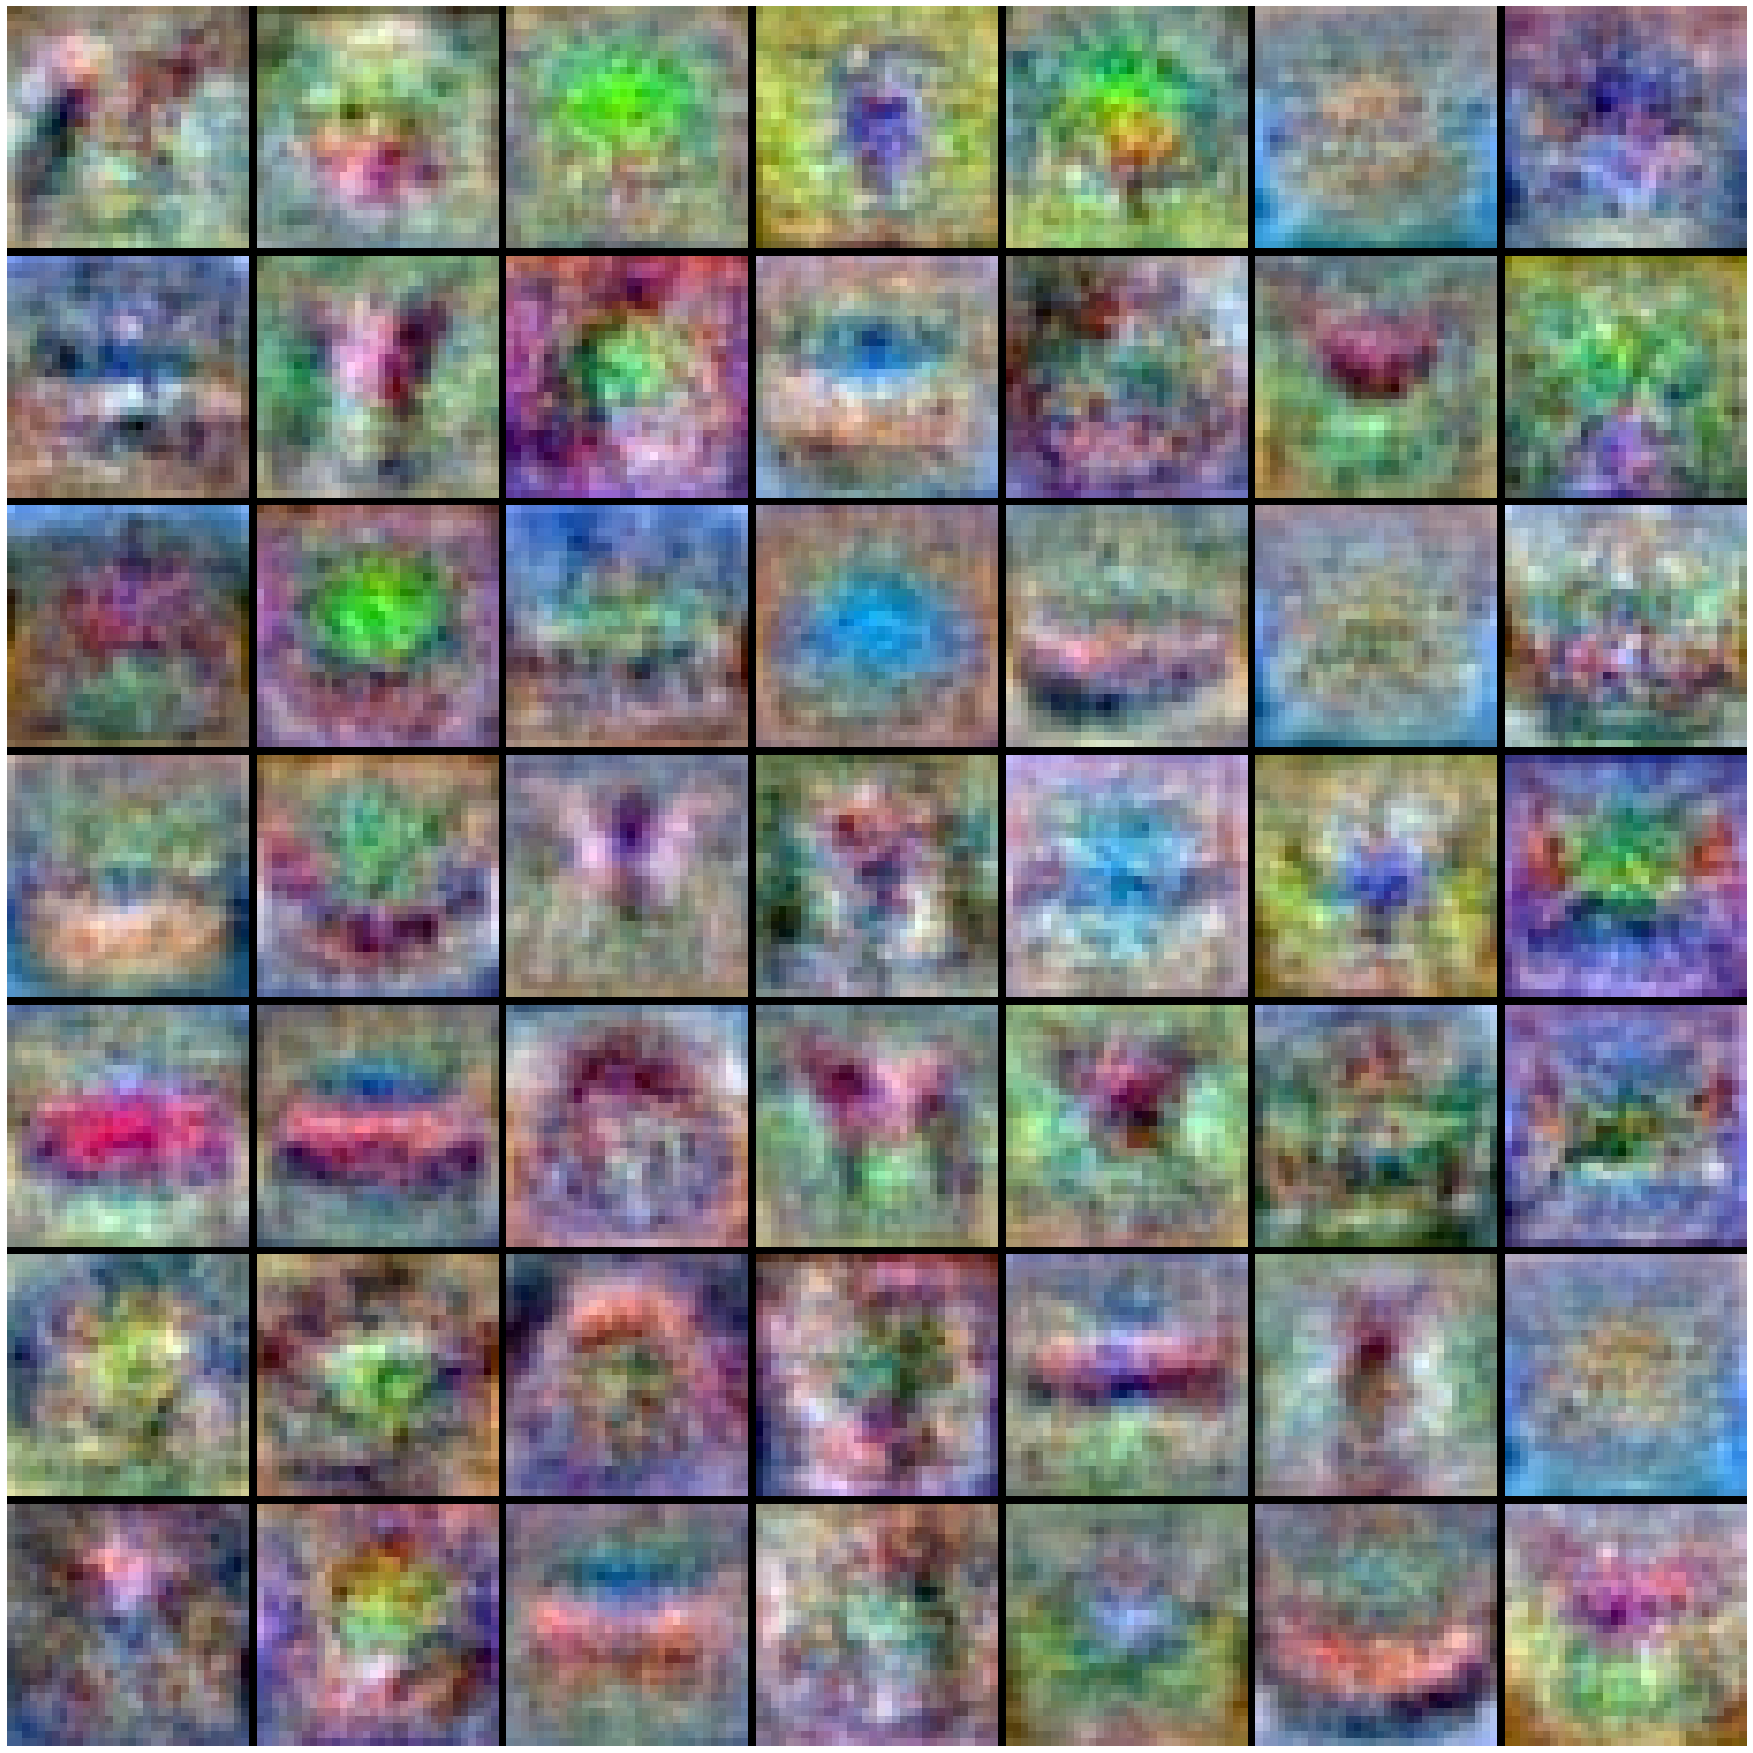

Plot weights for weight_size 7.000000 center_dist 30.000000


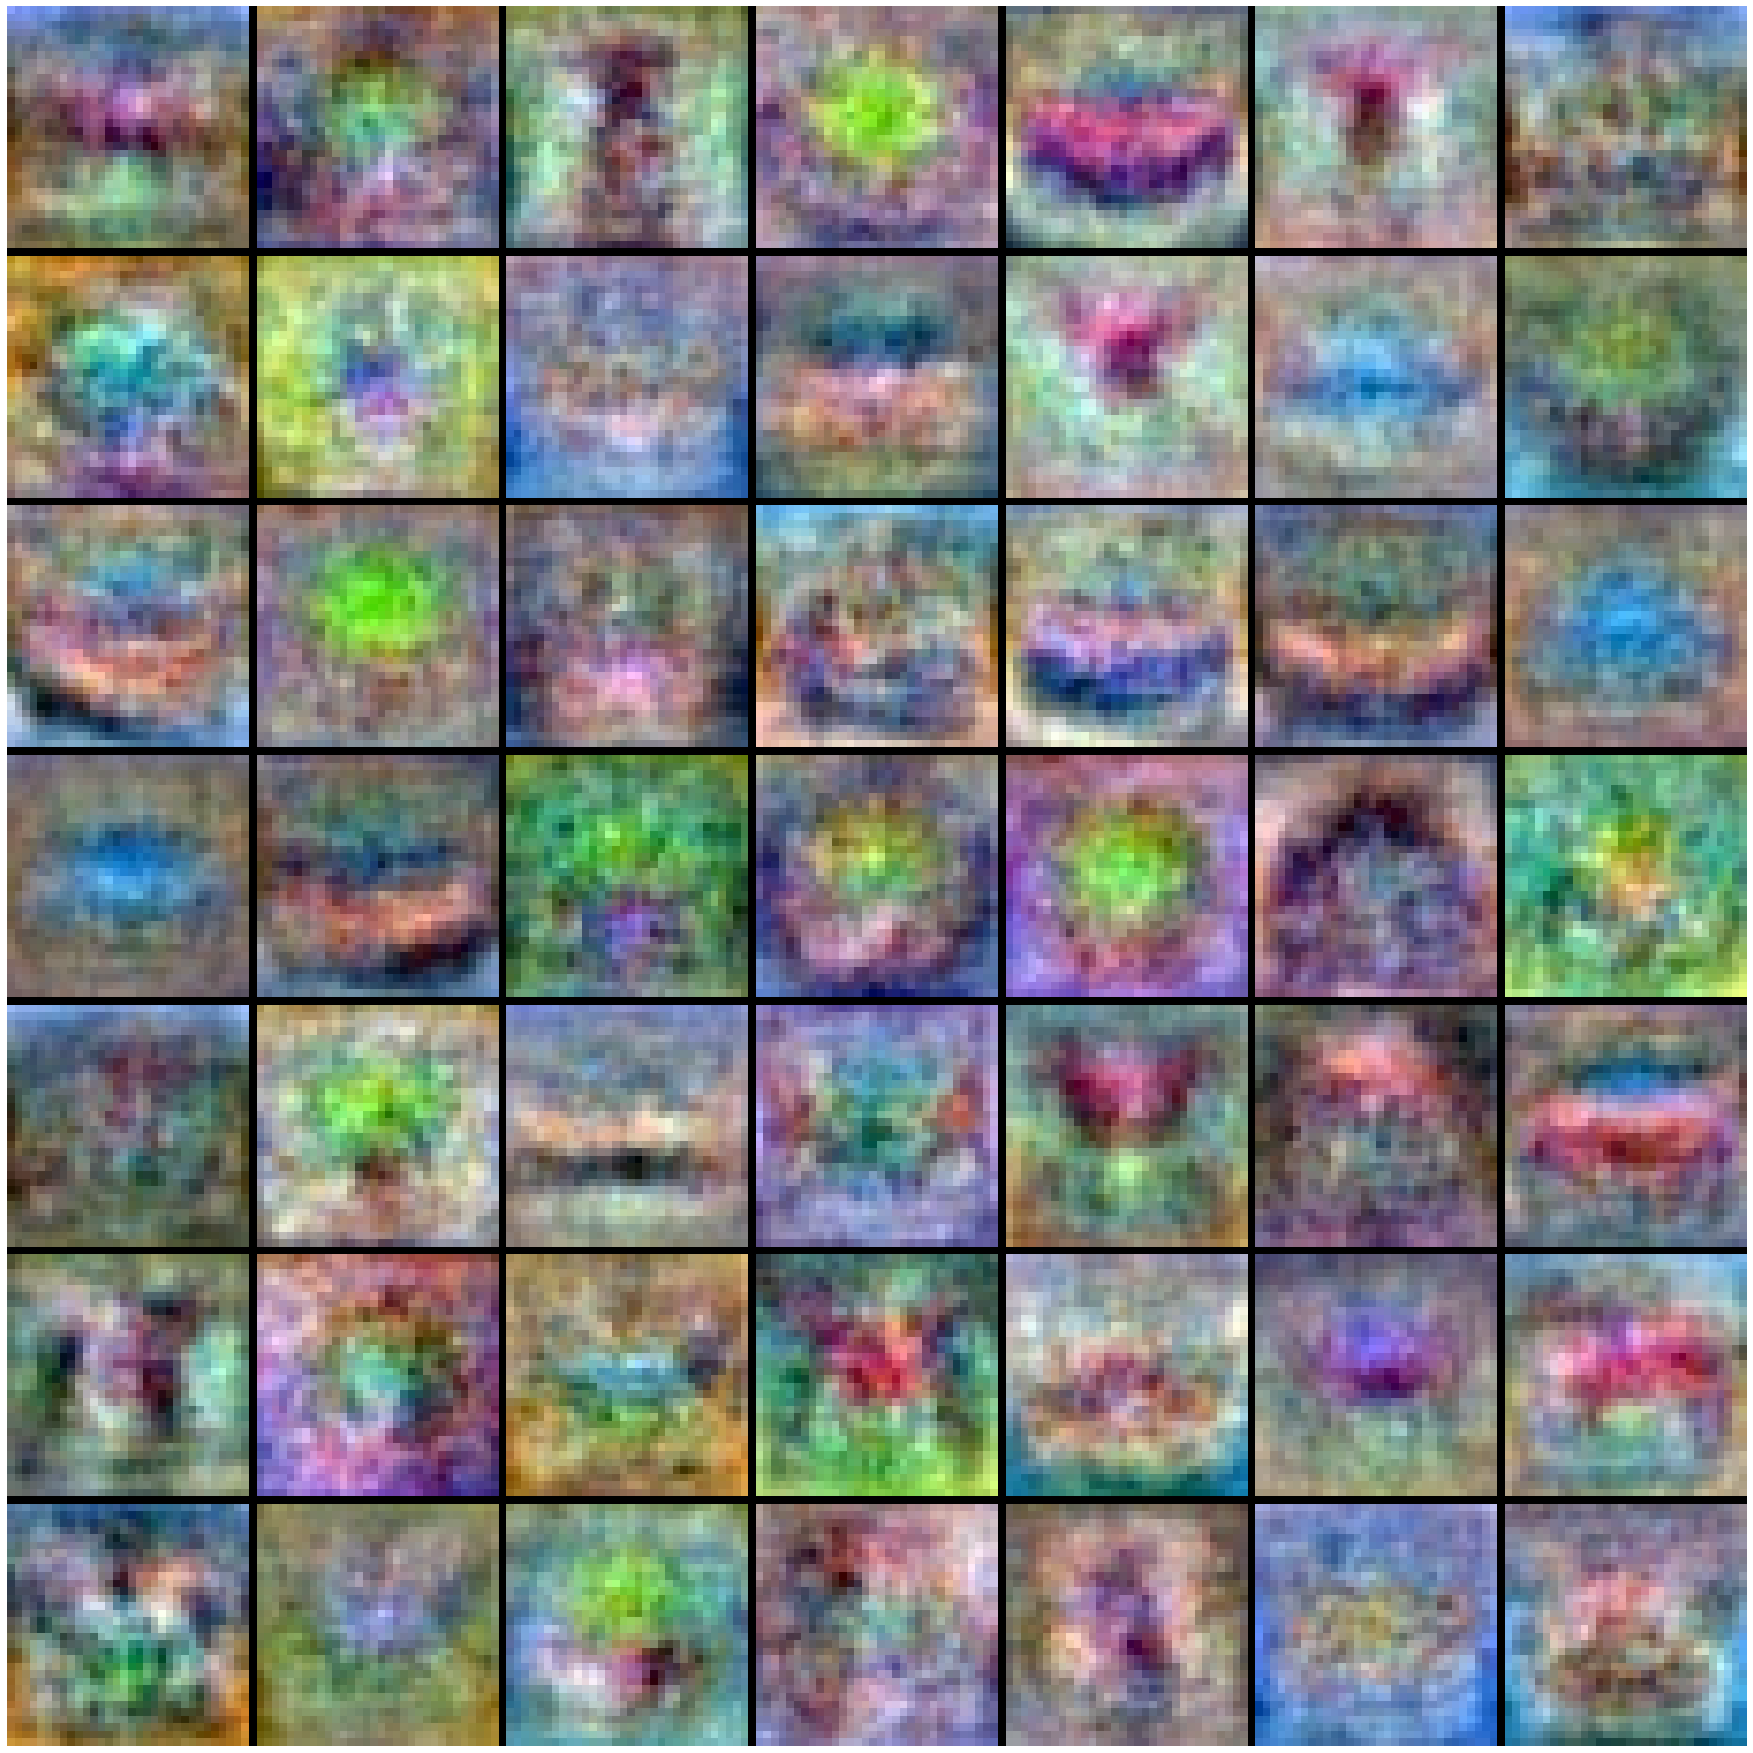

Plot weights for weight_size 7.000000 center_dist 35.000000


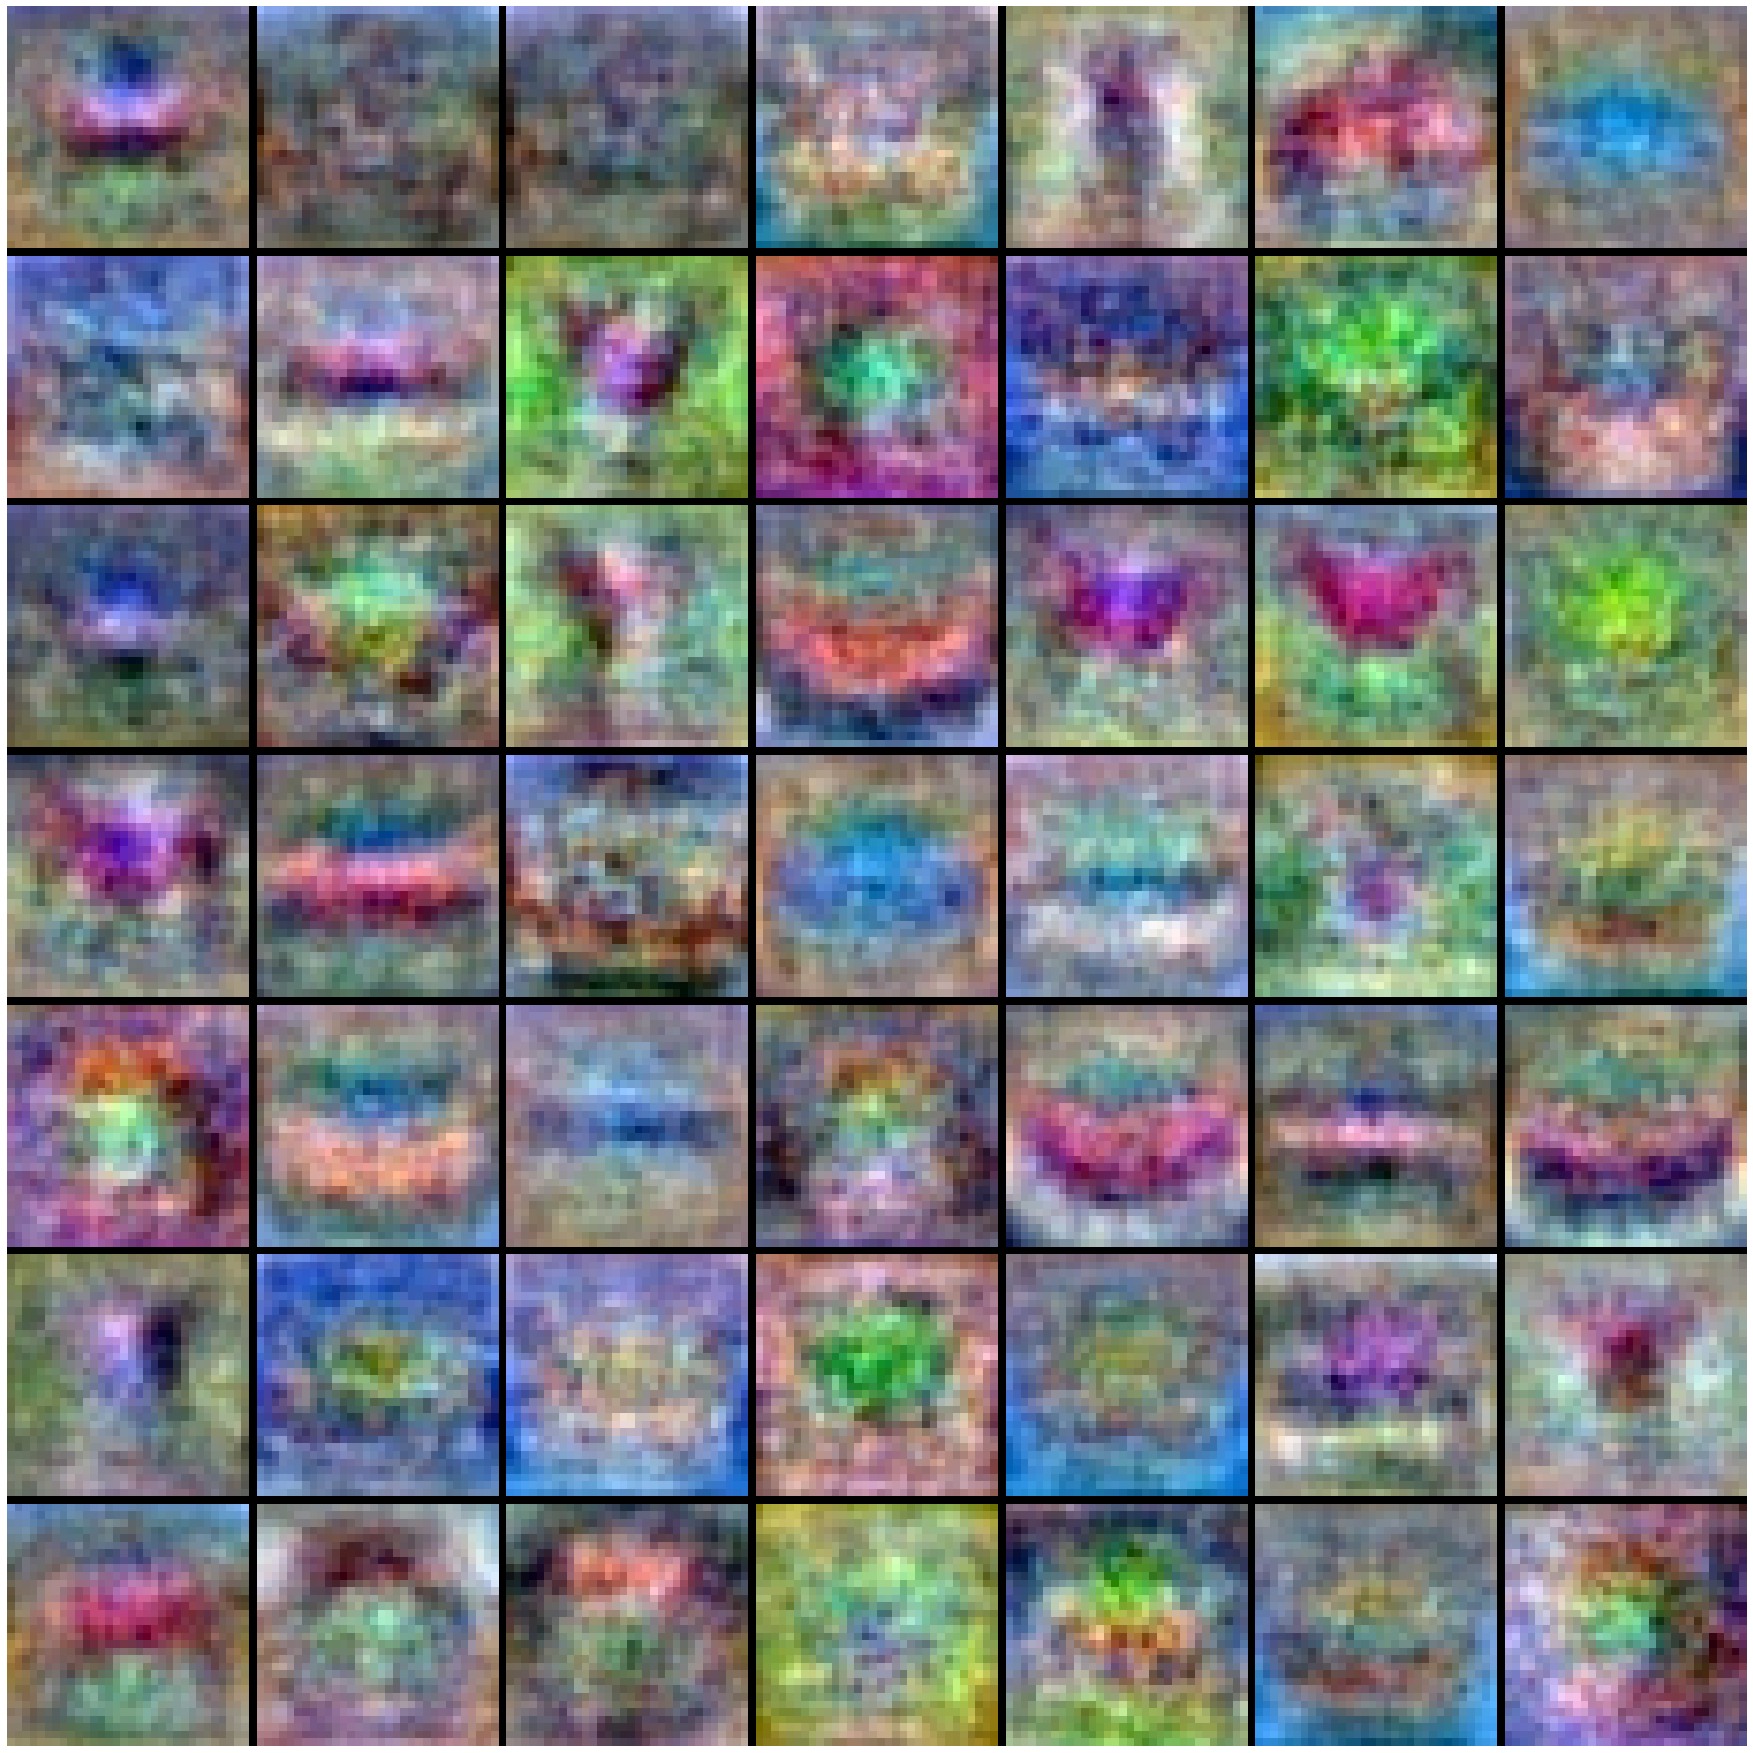

Plot weights for weight_size 7.000000 center_dist 40.000000


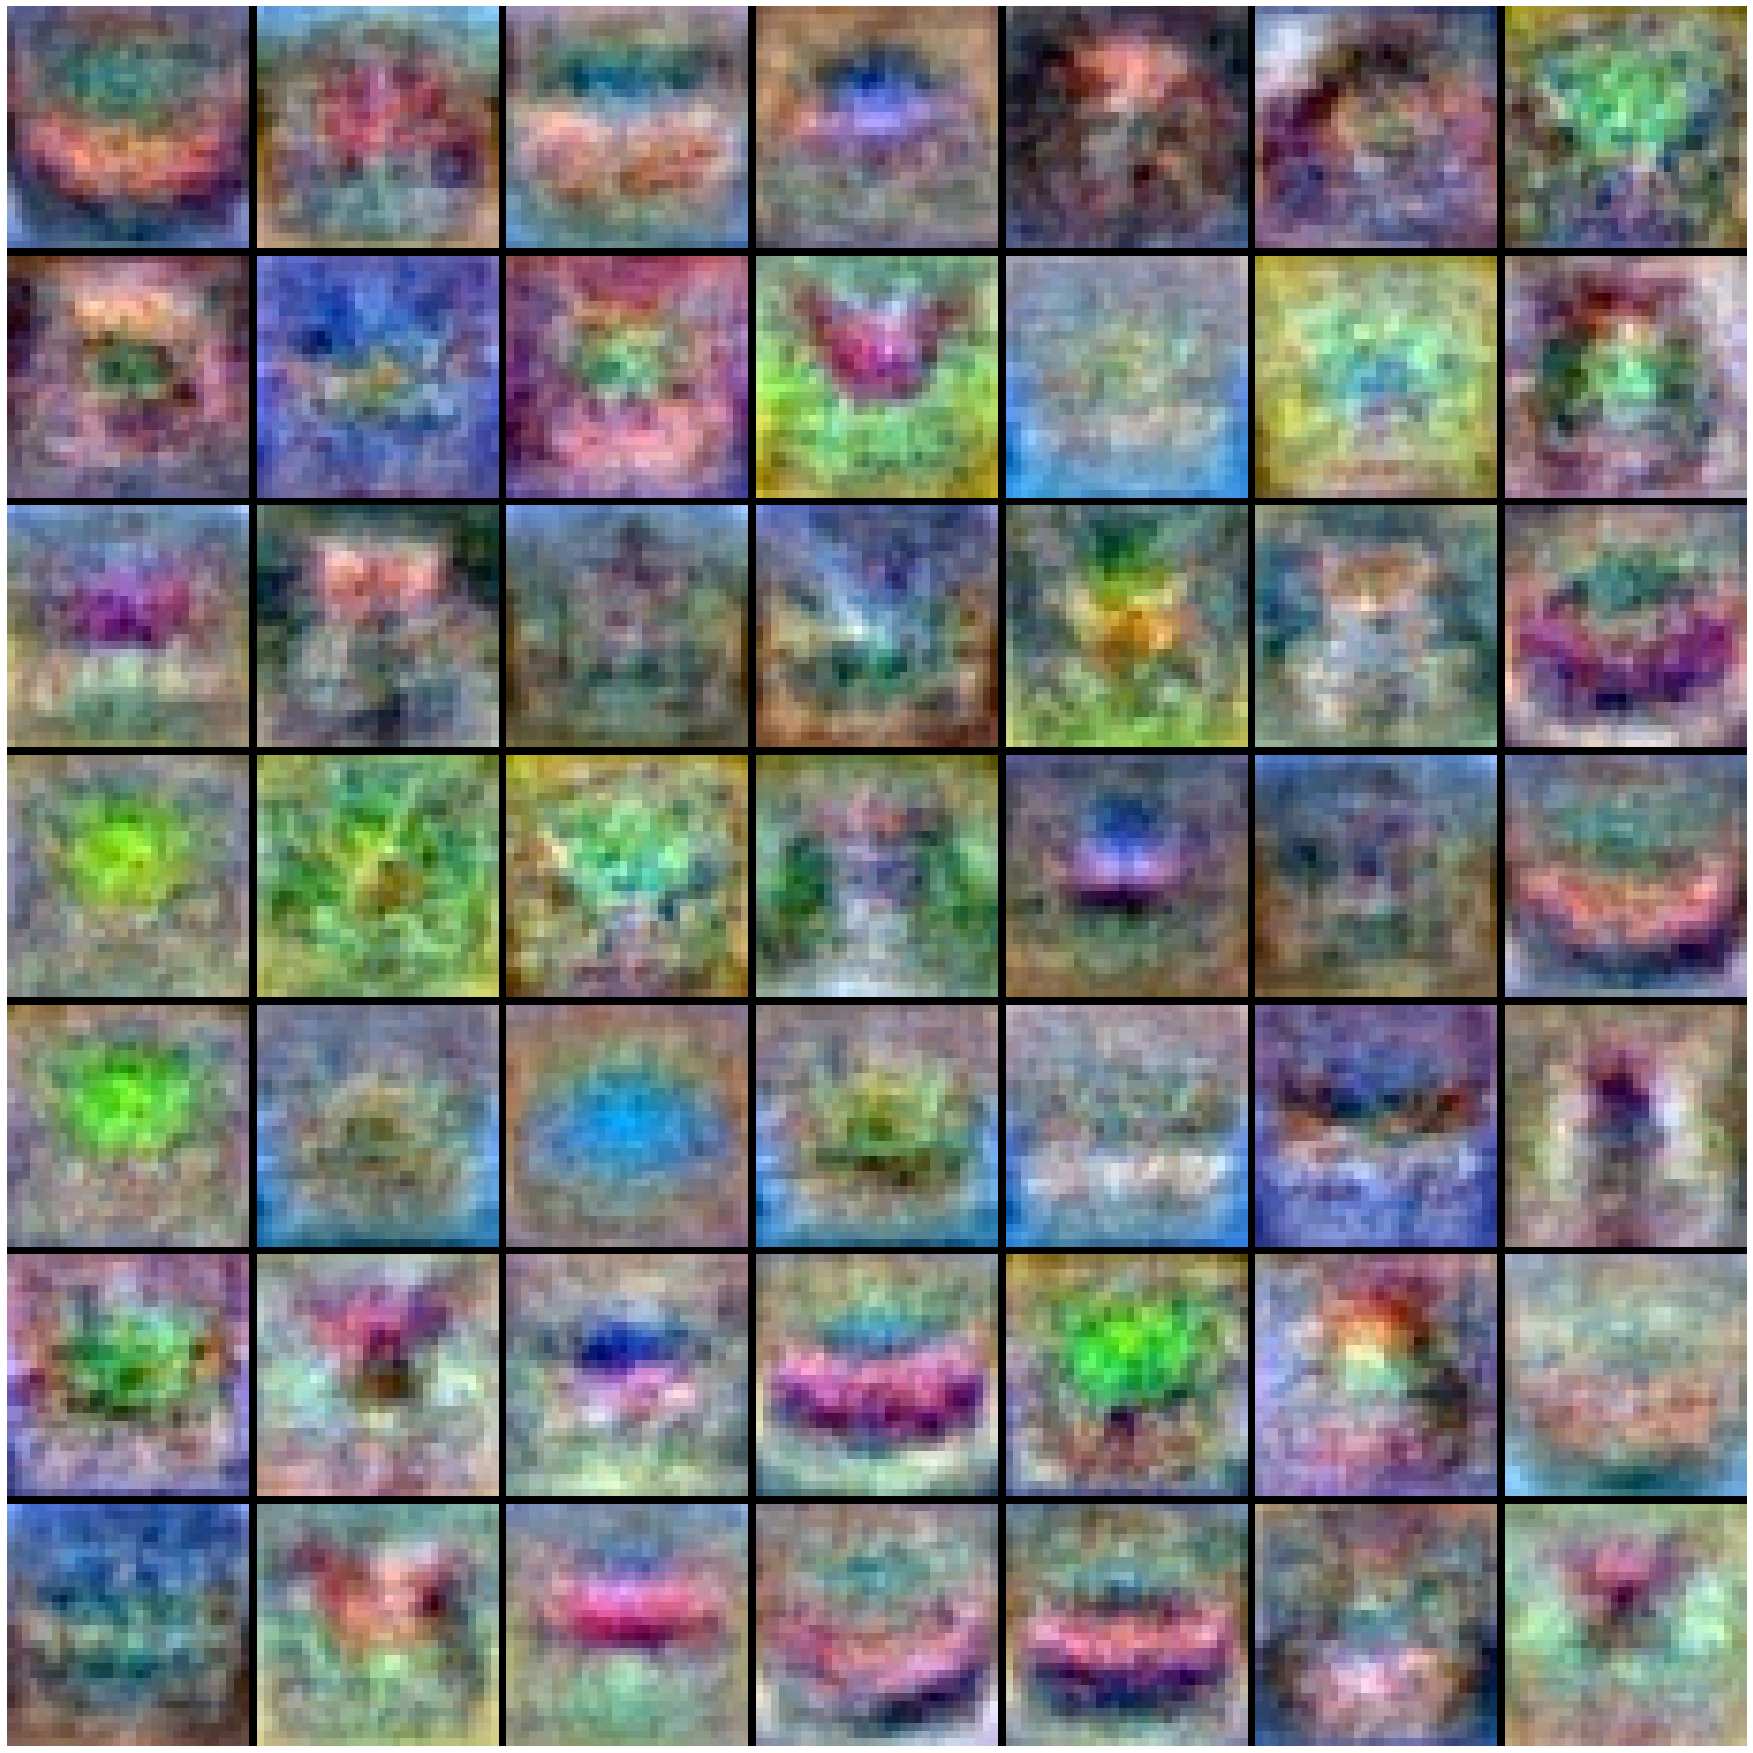

Plot weights for weight_size 7.000000 center_dist 45.000000


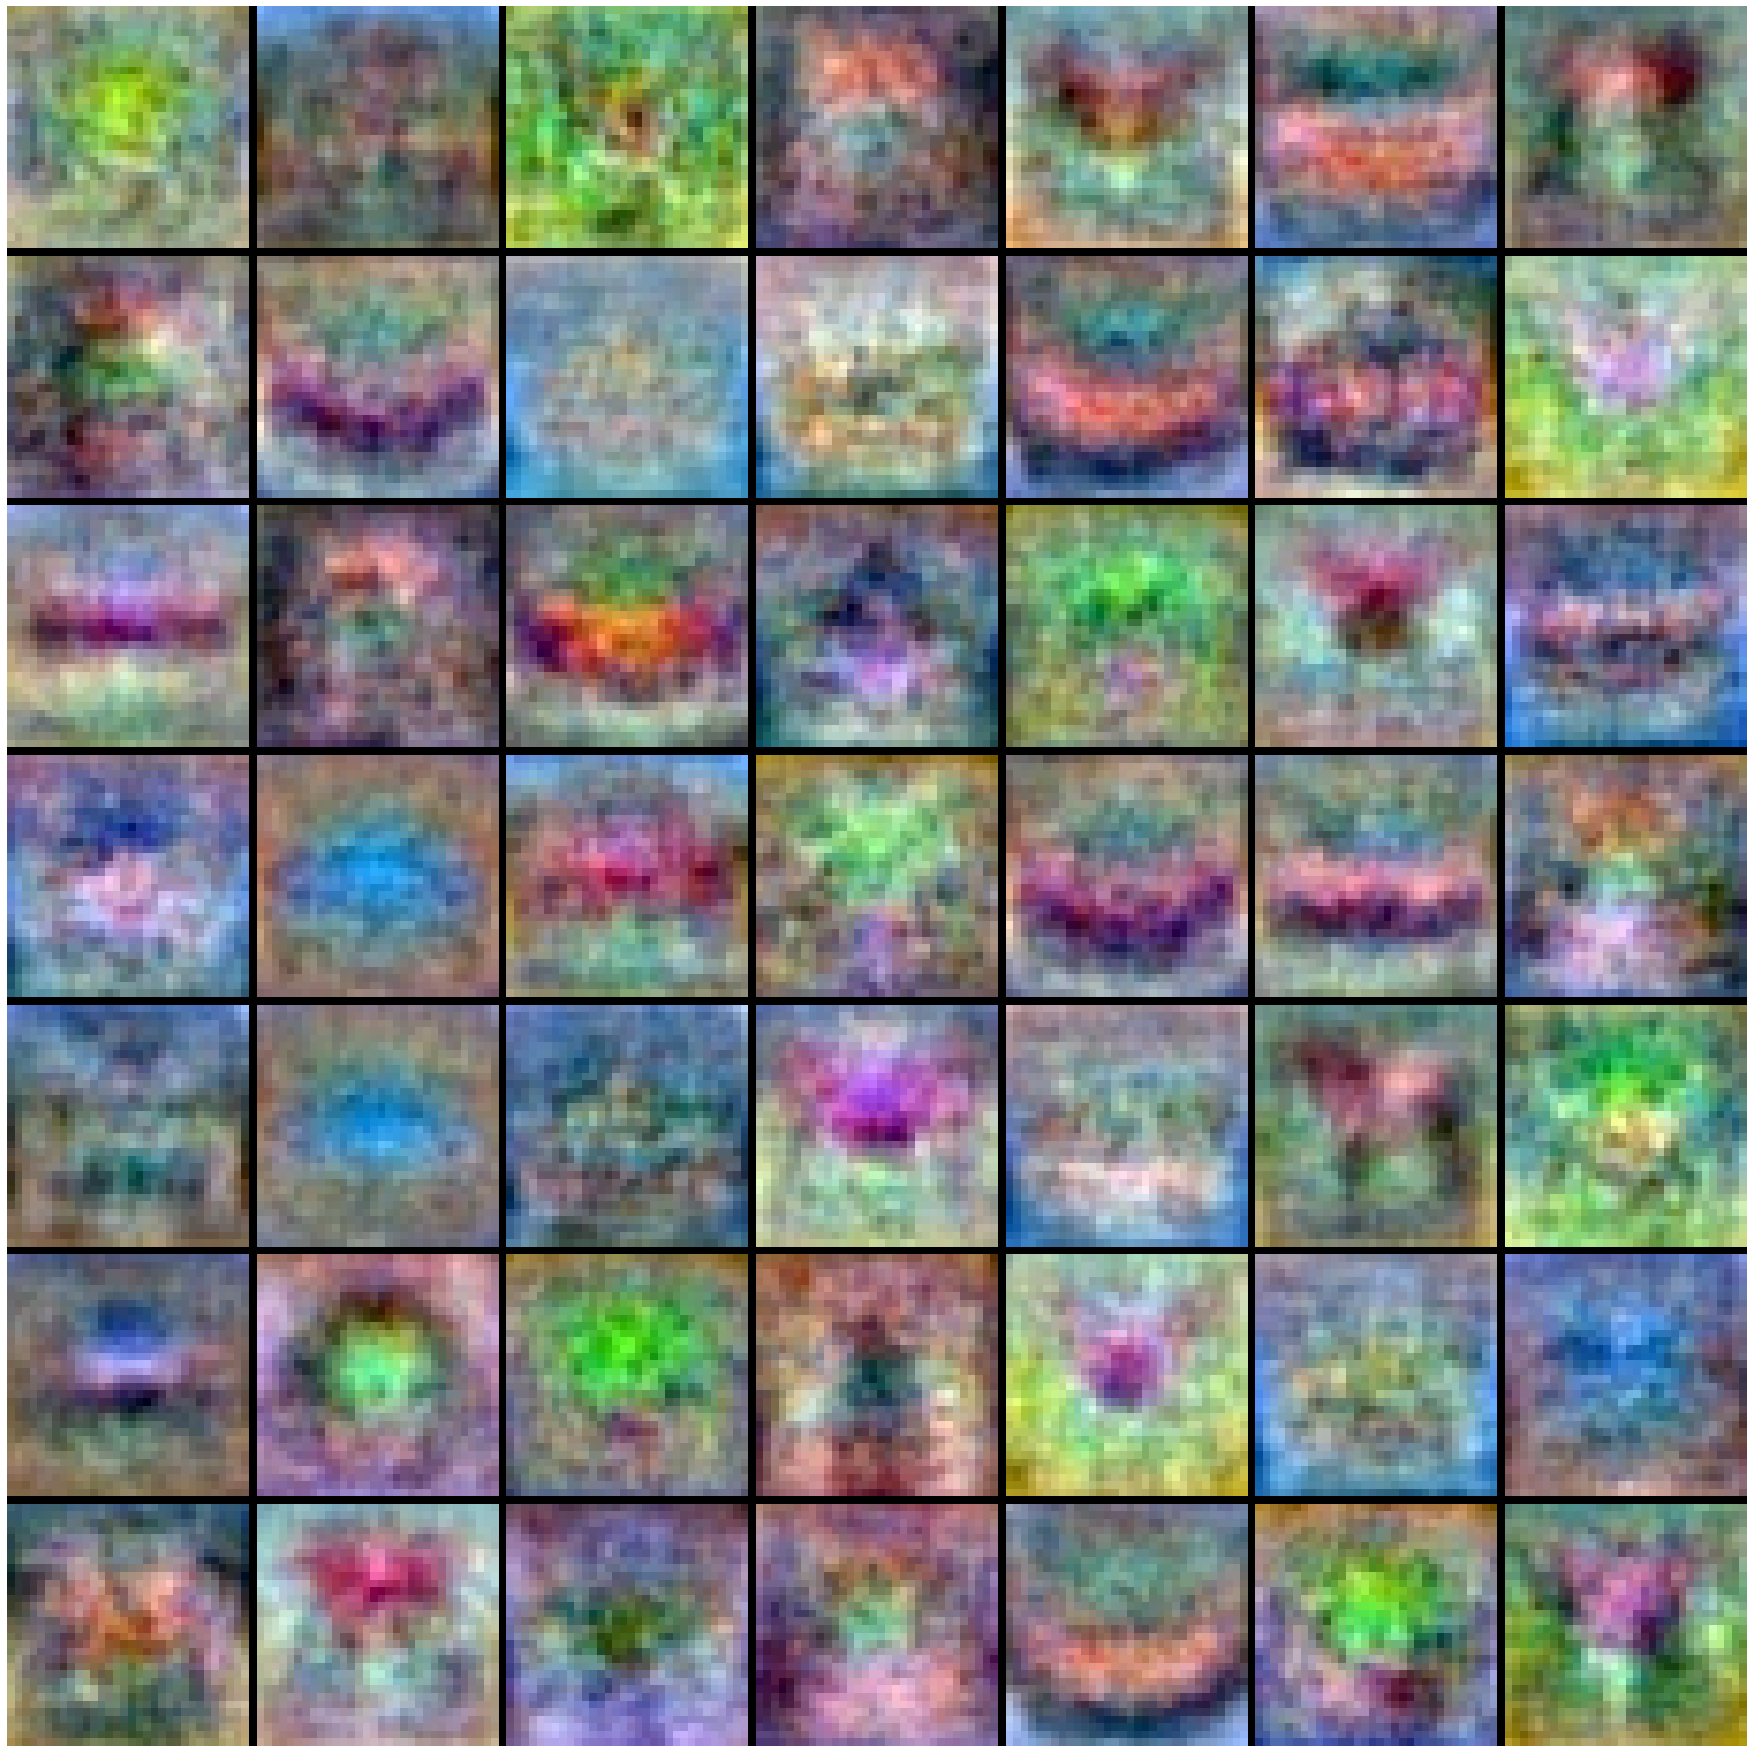

Plot weights for weight_size 7.000000 center_dist 50.000000


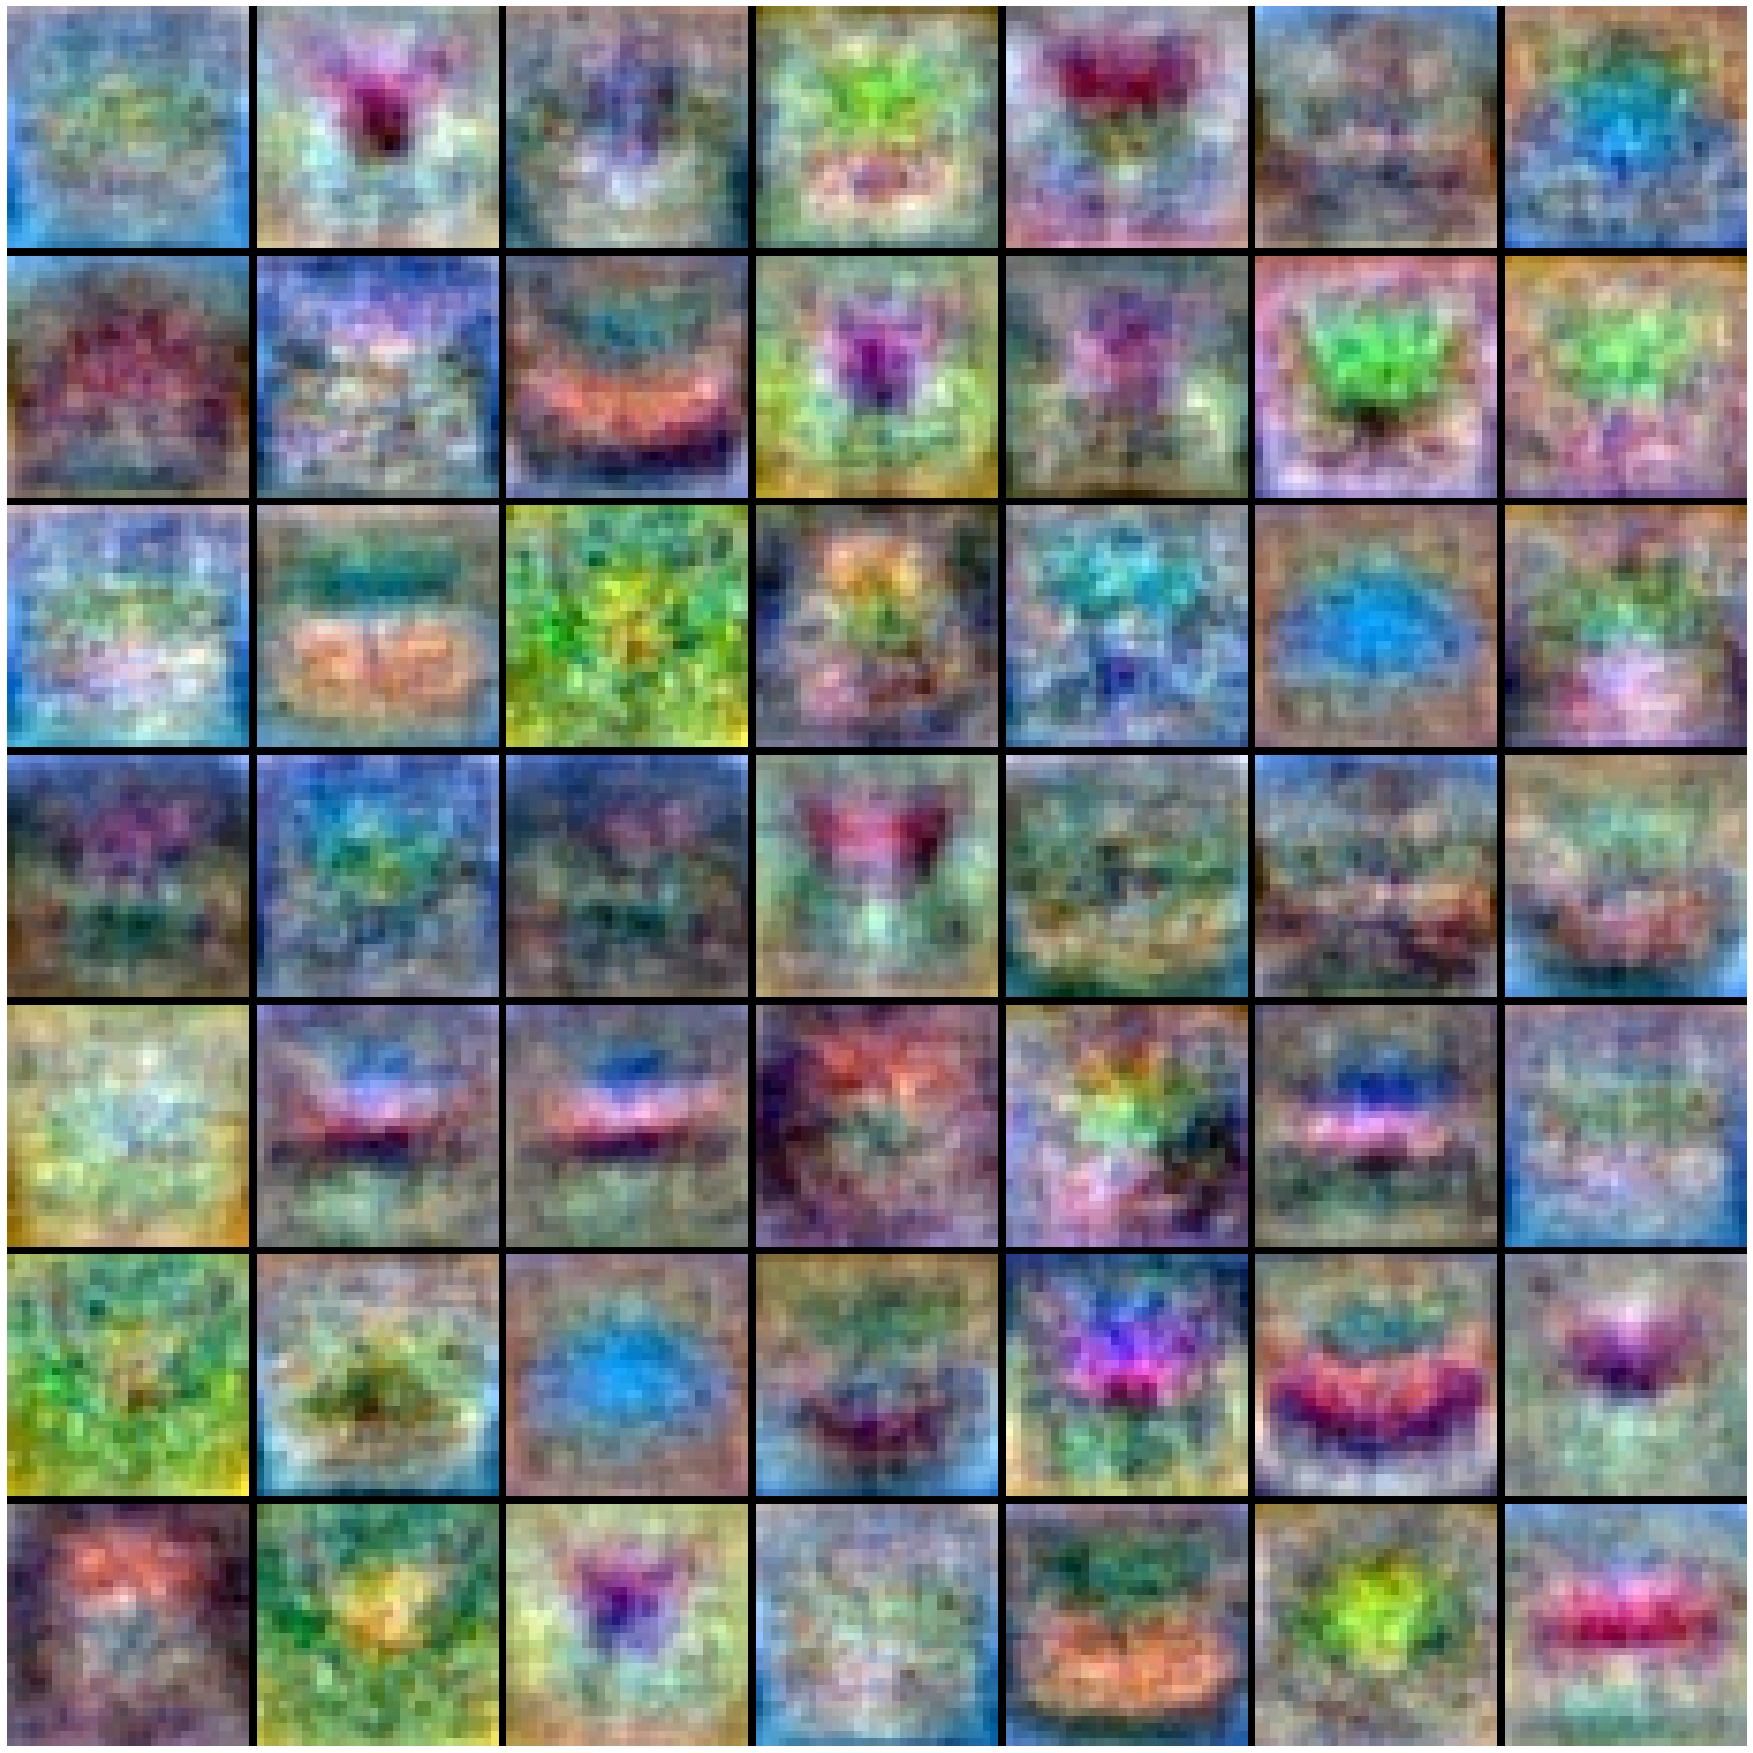

Plot weights for weight_size 7.000000 center_dist 55.000000


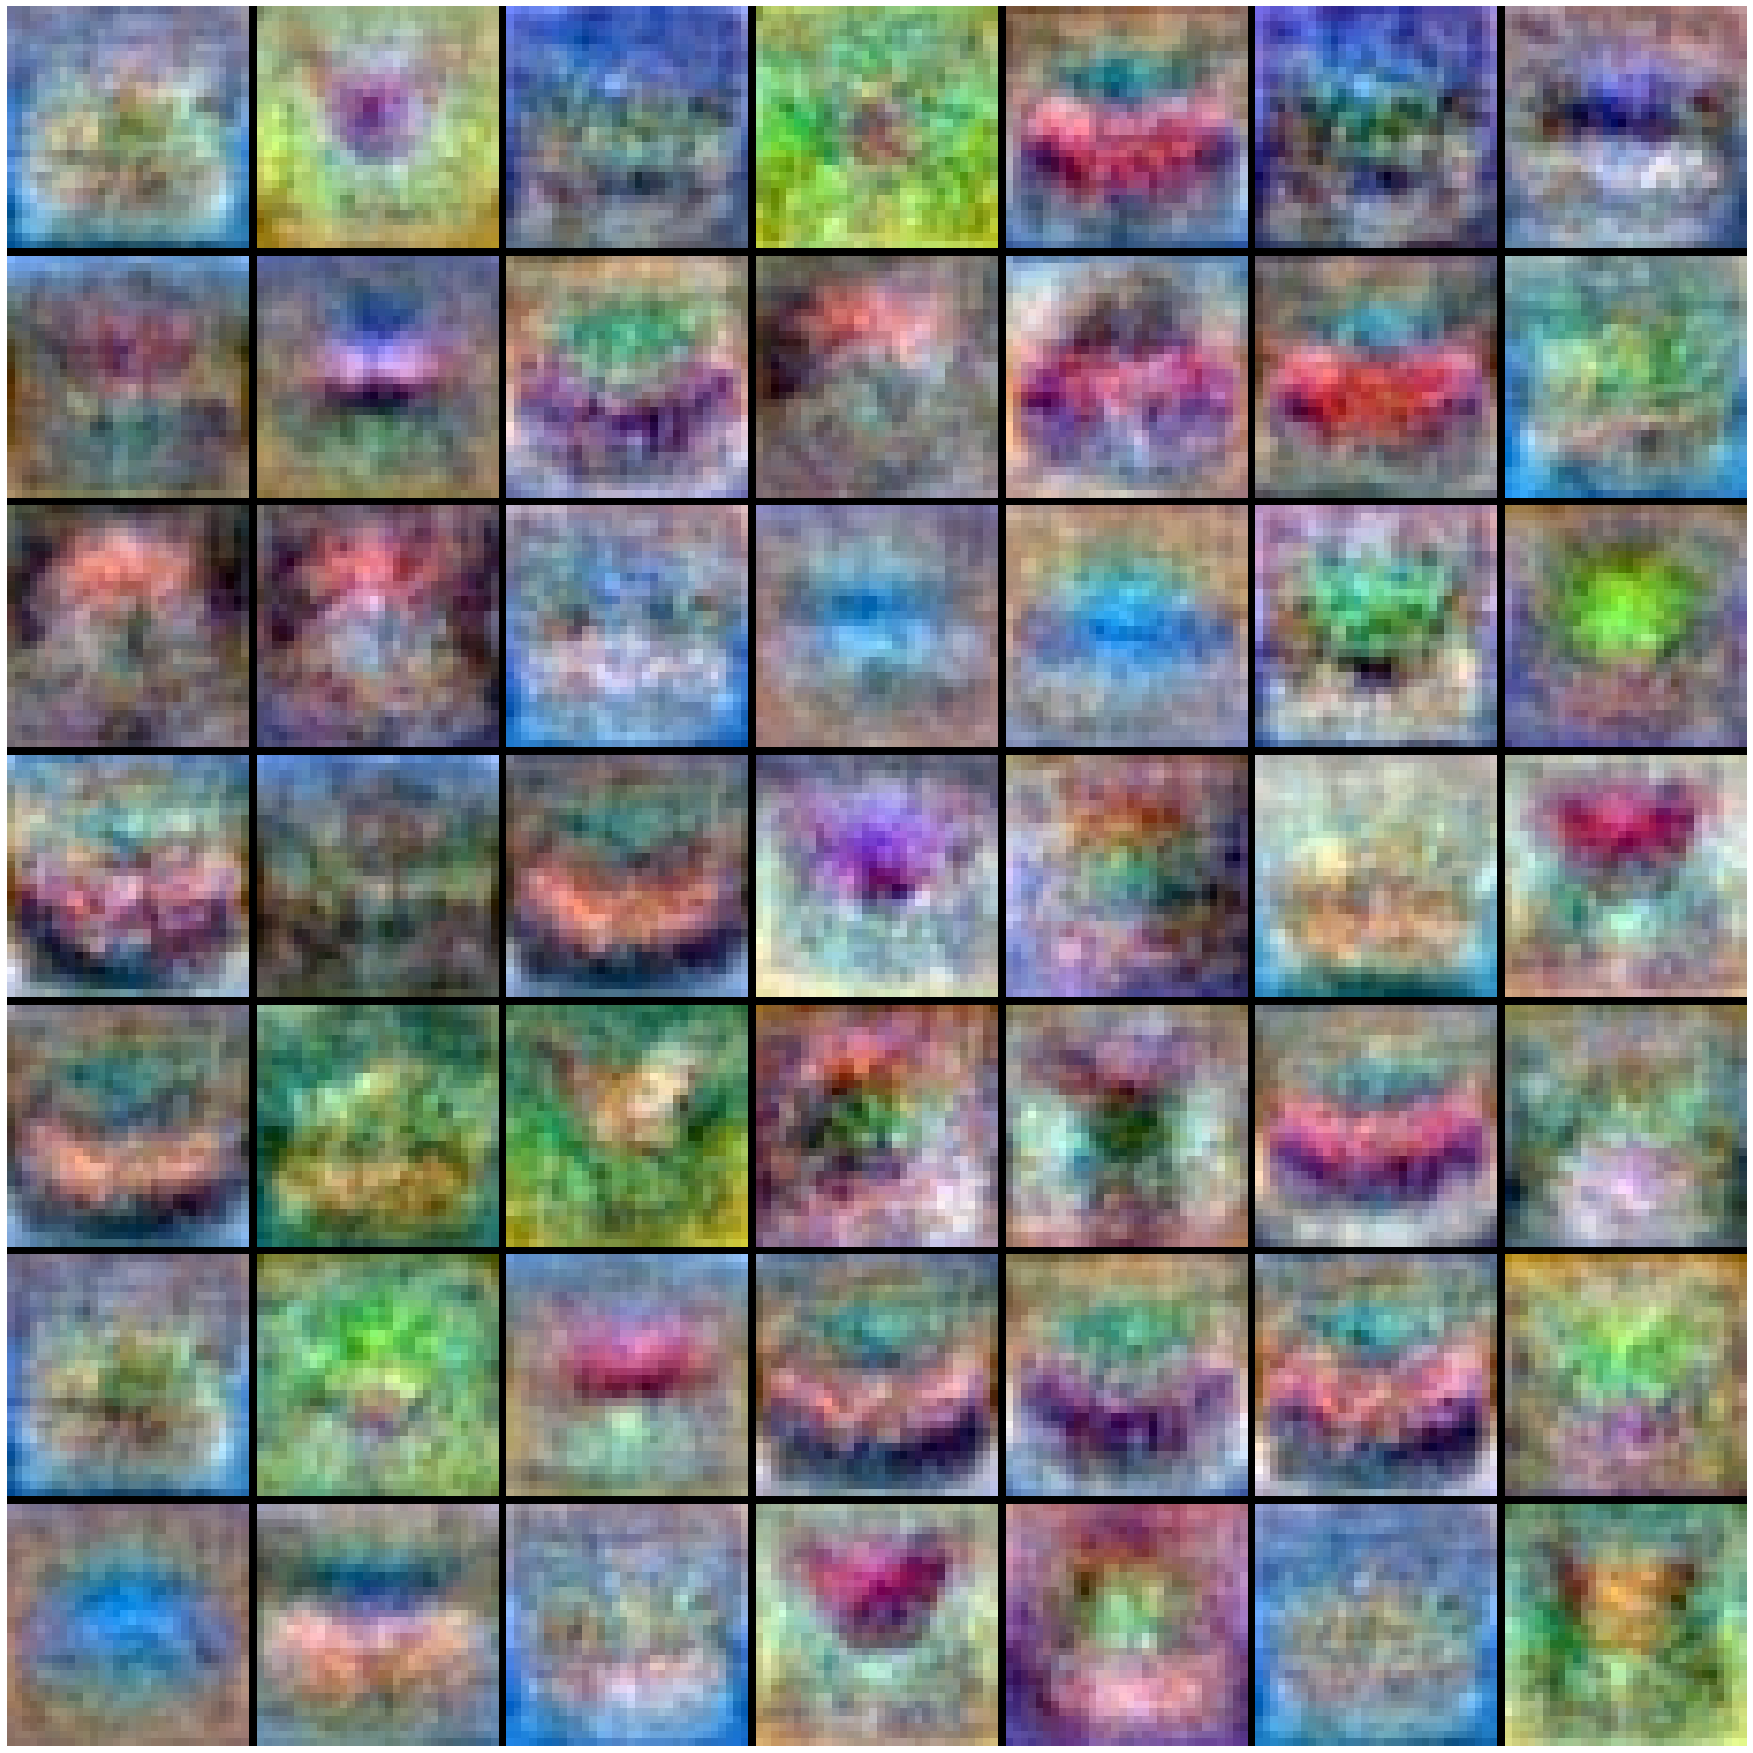

In [56]:
# Visualize the learned weights for each class
for weight_size in weight_sizes:
    for center_dist in center_dists:
        print('Plot weights for weight_size %f center_dist %f' % (weight_size, center_dist))
        
        # Visualize the learned weights for each class
        w = weights[(weight_size, center_dist)].transpose(0,1,3,2)
        num_plots = num_filters*weight_size*weight_size
        w = w.reshape(num_plots, 3, 32, 32).transpose(0,2,3,1)

        grid = visualize_grid(w)
        plt.imshow(grid.astype('uint8'))
        plt.axis('off')
        plt.gcf().set_size_inches(32, 32)
        plt.show()
        
        

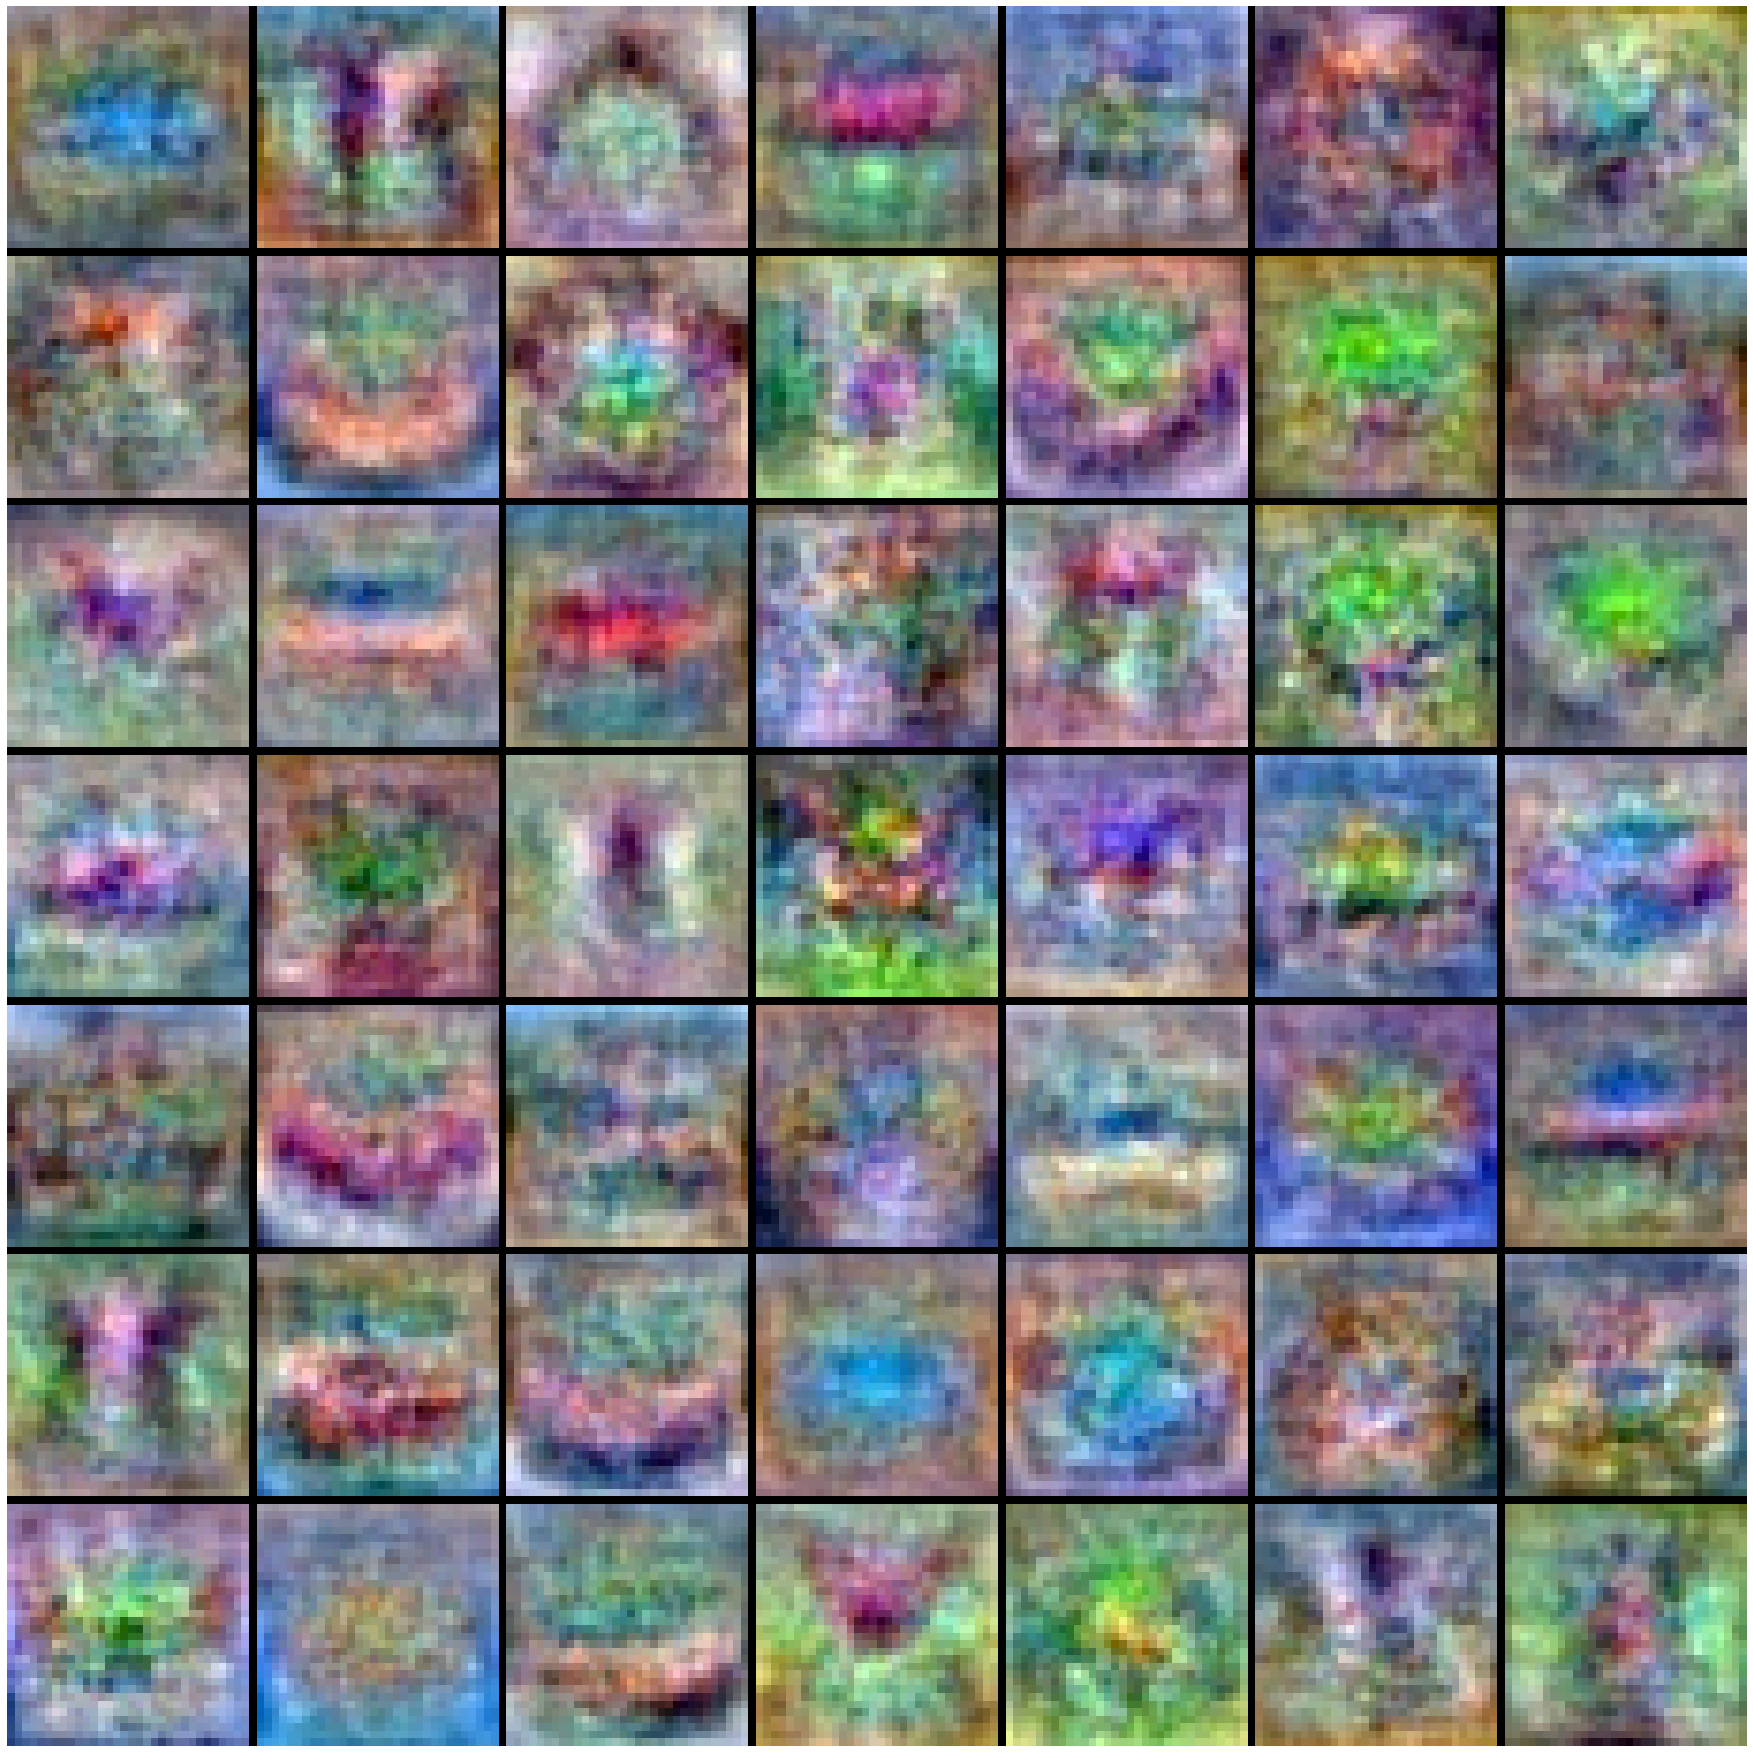

In [52]:
# Visualize the learned weights for each class
w = best_model.params['W1'].reshape(49, 3, 32, 32).transpose(0,2,3,1)

grid = visualize_grid(w)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(32, 32)
plt.show()

## Test your model!

In [59]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.505
Test set accuracy:  0.492


## Compare to Conv

In [ ]:
conv_model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

conv_solver = Solver(conv_model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=490)
t0 = time()
conv_solver.train()
t1 = time()
print('ThreeLayerCNNNet train: %fs' % (t1 - t0))

## Compare to FC

## CIFAR-100

In [67]:
from CIFAR_100.data_utils import get_CIFAR100_data
from CIFAR_100.data_utils import get_CIFAR100_superclass_data
cifar100_data = get_CIFAR100_data()
for k, v in cifar100_data.items():
  print('%s: ' % k, v.shape)

cifar_superclass_data = get_CIFAR100_superclass_data()
for k, v in cifar_superclass_data.items():
  print('%s: ' % k, v.shape)


X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)
X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


In [71]:
# Fixed parameters
input_dim = (3, 32, 32)
hidden_dim = 500
num_classes = 100
weight_scale = 1e-2
reg = 1e-3

num_filters = 1
weight_size = 7
center_dist = 15

model = ThreeLayerLCNNet(input_dim,
                         num_filters,
                         weight_size,
                         hidden_dim,
                         num_classes,
                         weight_scale,
                         reg,
                         center_dist
                        )

solver = Solver(model, cifar100_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=980)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet train: %fs' % (t1 - t0))

(Iteration 1 / 14700) loss: 4.616389
(Epoch 0 / 15) train acc: 0.013000; val_acc: 0.017000
(Epoch 1 / 15) train acc: 0.178000; val_acc: 0.134000
(Iteration 981 / 14700) loss: 3.714592
(Epoch 2 / 15) train acc: 0.202000; val_acc: 0.170000
(Iteration 1961 / 14700) loss: 3.234798
(Epoch 3 / 15) train acc: 0.230000; val_acc: 0.192000
(Iteration 2941 / 14700) loss: 3.015755
(Epoch 4 / 15) train acc: 0.239000; val_acc: 0.204000
(Iteration 3921 / 14700) loss: 3.341226
(Epoch 5 / 15) train acc: 0.273000; val_acc: 0.223000
(Iteration 4901 / 14700) loss: 3.066682
(Epoch 6 / 15) train acc: 0.266000; val_acc: 0.214000
(Iteration 5881 / 14700) loss: 3.488621
(Epoch 7 / 15) train acc: 0.284000; val_acc: 0.223000
(Iteration 6861 / 14700) loss: 3.343210
(Epoch 8 / 15) train acc: 0.284000; val_acc: 0.231000
(Iteration 7841 / 14700) loss: 2.954776
(Epoch 9 / 15) train acc: 0.305000; val_acc: 0.247000
(Iteration 8821 / 14700) loss: 3.262804
(Epoch 10 / 15) train acc: 0.308000; val_acc: 0.246000
(Iteratio

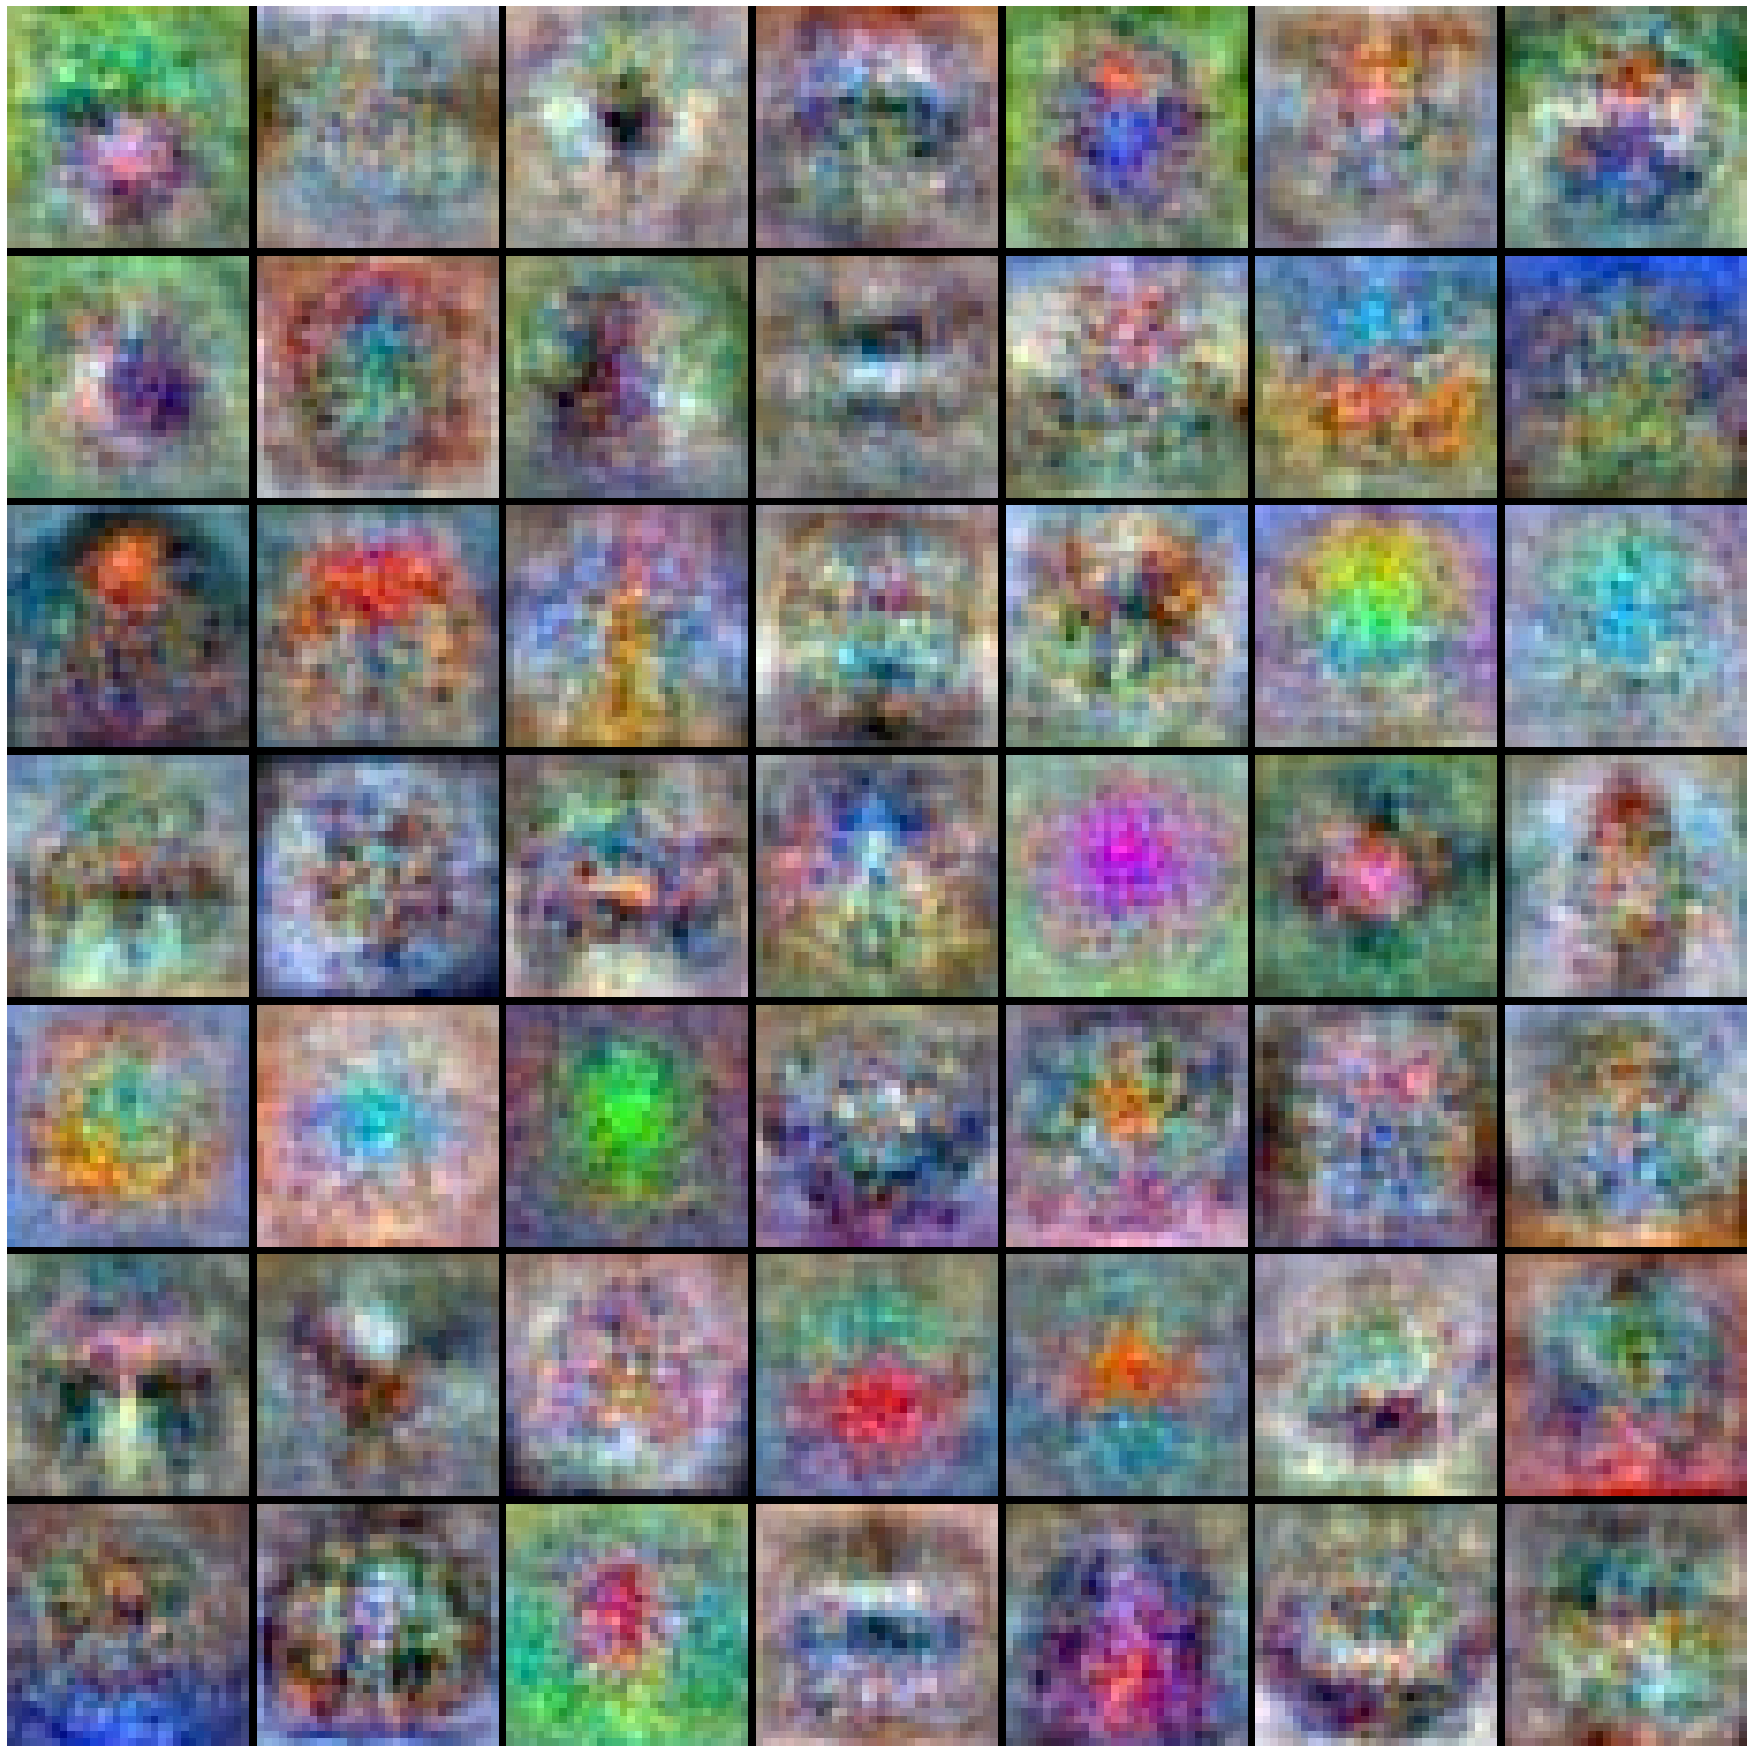

In [72]:
# Visualize the learned weights for each class
w = model.params['W1'].reshape(49, 3, 32, 32).transpose(0,2,3,1)

grid = visualize_grid(w)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(32, 32)
plt.show()

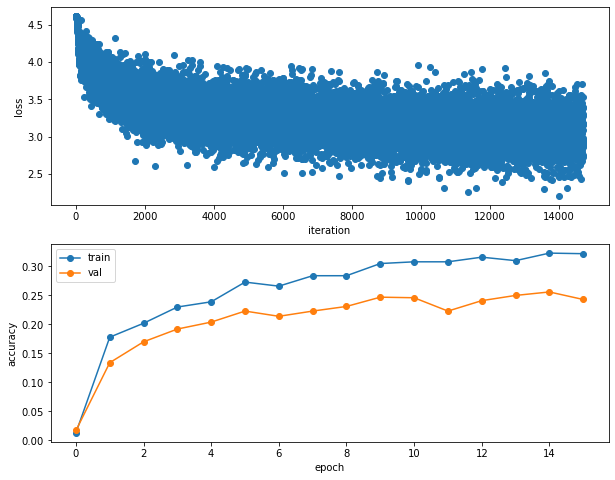

In [73]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [77]:
# Fixed parameters
input_dim = (3, 32, 32)
hidden_dim = 500
num_classes = 100
weight_scale = 1e-2
reg = 1e-3

num_filters = 1
weight_size = 7
center_dist = 15

model = ThreeLayerLCNNet(input_dim,
                         num_filters,
                         weight_size,
                         hidden_dim,
                         num_classes,
                         weight_scale,
                         reg,
                         center_dist
                        )

solver = Solver(model, cifar_superclass_data,
                num_epochs=30, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=980)
t0 = time()
solver.train()
t1 = time()
print('ThreeLayerLCNNet train: %fs' % (t1 - t0))

(Iteration 1 / 29400) loss: 4.616461
(Epoch 0 / 30) train acc: 0.076000; val_acc: 0.073000
(Epoch 1 / 30) train acc: 0.268000; val_acc: 0.261000
(Iteration 981 / 29400) loss: 2.420972
(Epoch 2 / 30) train acc: 0.348000; val_acc: 0.300000
(Iteration 1961 / 29400) loss: 2.207654
(Epoch 3 / 30) train acc: 0.339000; val_acc: 0.315000
(Iteration 2941 / 29400) loss: 1.939349
(Epoch 4 / 30) train acc: 0.372000; val_acc: 0.334000
(Iteration 3921 / 29400) loss: 1.943483
(Epoch 5 / 30) train acc: 0.389000; val_acc: 0.324000
(Iteration 4901 / 29400) loss: 2.286766
(Epoch 6 / 30) train acc: 0.391000; val_acc: 0.346000
(Iteration 5881 / 29400) loss: 2.278683
(Epoch 7 / 30) train acc: 0.362000; val_acc: 0.321000
(Iteration 6861 / 29400) loss: 2.153528
(Epoch 8 / 30) train acc: 0.398000; val_acc: 0.333000
(Iteration 7841 / 29400) loss: 1.959633
(Epoch 9 / 30) train acc: 0.381000; val_acc: 0.348000
(Iteration 8821 / 29400) loss: 2.030142
(Epoch 10 / 30) train acc: 0.391000; val_acc: 0.342000
(Iteratio

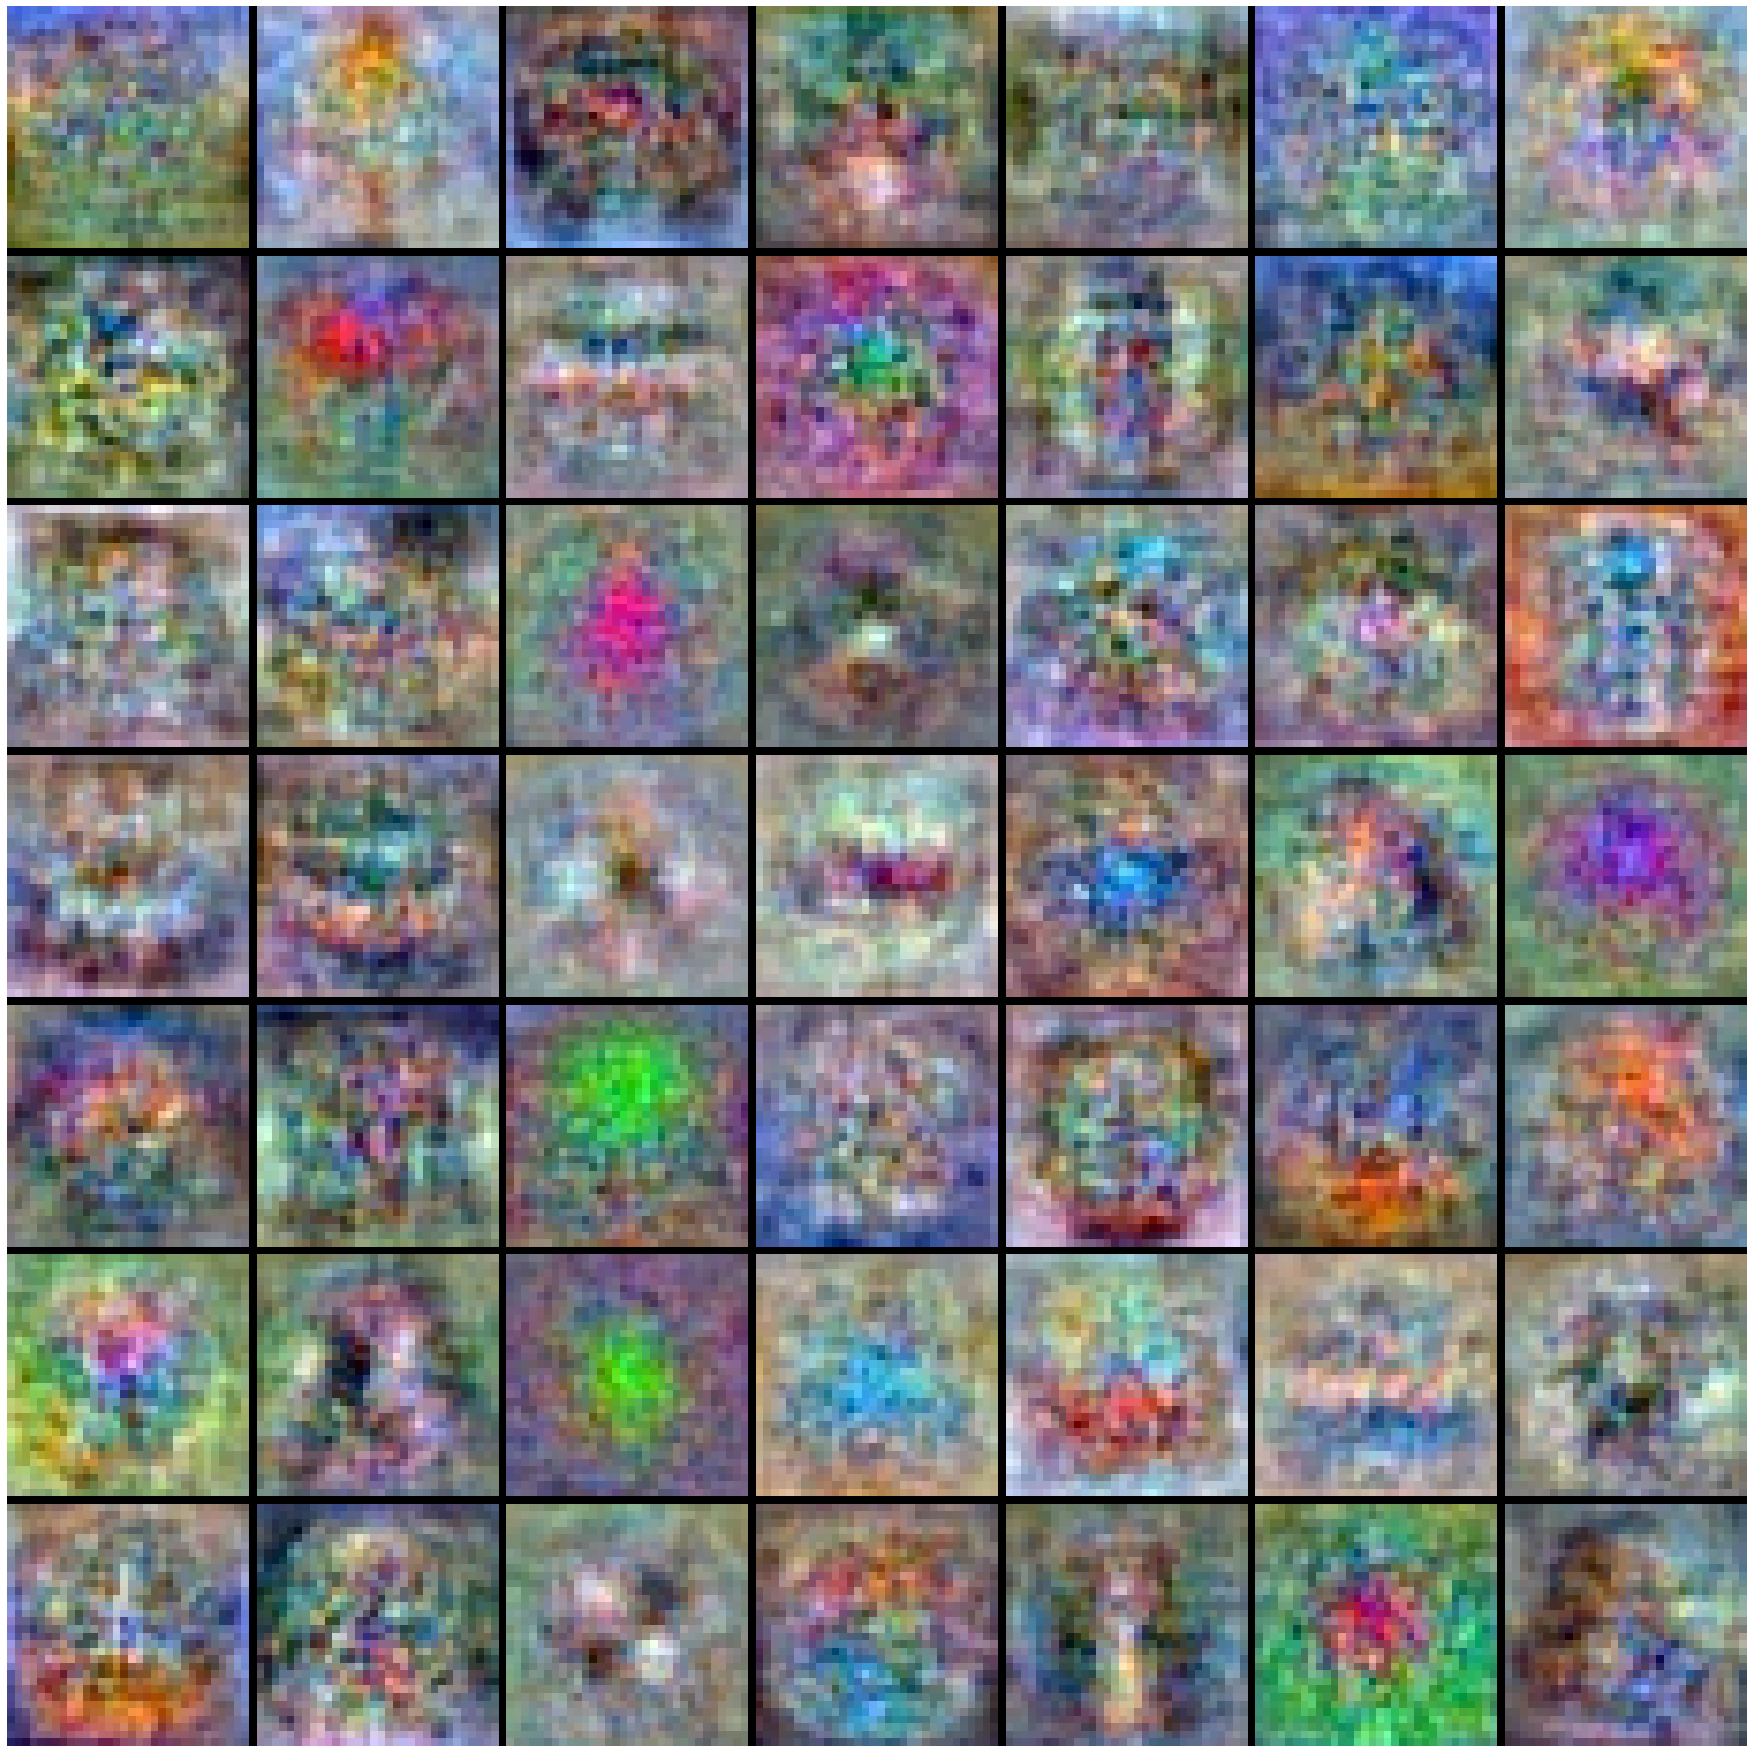

In [78]:
w = model.params['W1'].reshape(49, 3, 32, 32).transpose(0,2,3,1)

grid = visualize_grid(w)
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(32, 32)
plt.show()

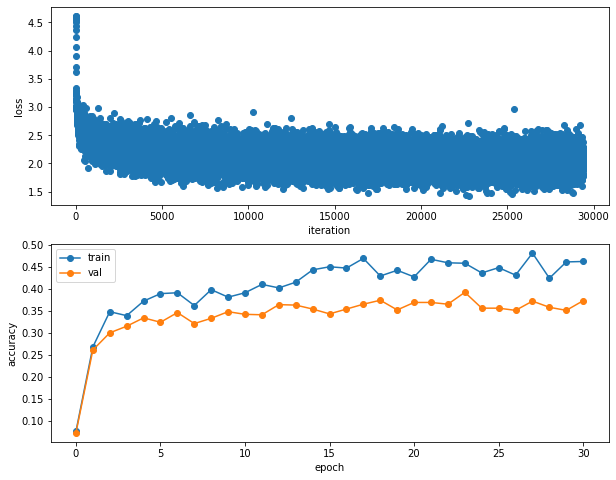

In [79]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()